<a href="https://www.kaggle.com/code/calistusmwonga/final-notebook-landslide-detection?scriptVersionId=255661626" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/calistusmwonga/cnn-tree-markdowns-version?scriptVersionId=255406670" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/calistusmwonga/cnn-xgbm-sotr-efficientnetv2b0173ef58638?scriptVersionId=254960407" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **CLASSIFICATION FOR LANDSLIDE DETECTION**


# 1. **Business Understanding**

## 1.1 Problem Statement

- Landslides are critical natural hazards, often triggered by extreme weather and seismic events. The impact on human lives, property, and infrastructure is significant, making rapid and accurate detection essential for effective disaster management and climate resilience planning.
- Traditional monitoring methods relying solely on optical satellite imagery often fail due to persistent cloud cover, which is frequently present during the storm events that trigger landslides. This delay in detection creates a critical information gap, That hampers risk assessment when they are needed most. There is a clear business need for a reliable detection system that functions under all weather conditions, especially in remote or inaccessible regions.

## 1.2 Project Aim:
- The aim of this project is to develop an AI-based system for detecting and classifying landslides using satellite and radar imagery. This system will support disaster management agencies by providing timely and reliable detection, and will assist geospatial researchers in understanding patterns and impacts of landslide events.

## 1.3 Project Objectives
To address this problem, this project will deliver an AI system with the following primary objectives:
1. To build and evaluate a machine learning model capable of accurately classifying landslide events by synergistically using both all-weather Synthetic Aperture Radar (SAR) data and traditional optical satellite imagery.
2. To perform domain-specific feature engineering by testing out various engineered features to determine whether they offer a stronger predictive signal than the raw spatial patterns alone.  
3. To implement Explainable AI (XAI) techniques using SHARP on the most successful model. This is to prevent developing a black-box model and instead provide a clear understanding into how the model came to it's coLnclusion by understanding which features are driving the detection of a landslide which makes it trustworthy for stakeholders



# 2. **DATA UNDERSTANDING**

## **2.1 Data Source** 
The dataset for this challenge is from https://zindi.africa/competitions/classification-for-landslide-detection/data 
- It contains multi-modal collection, combining satellite imagery from two distinct sources to provide a comprehensive view of ground conditions.
  
**These two types of data are:**
1. *Optical Imagery (Sentinel-2)*: This data is sourced from the Sentinel-2 MultiSpectral Instrument (MSI). It provides high-resolution (10m) Red, Green, Blue, and Near-Infrared (NIR) bands. While it is highly interpretable, optical data is susceptible to obstruction by cloud cover.
2. *Radar Imagery (Sentinel-1):* This data provides all-weather imaging capabilities, which is crucial for monitoring events in cloud-covered regions. It includes Synthetic Aperture Radar (SAR) data with VV (Vertical-Vertical) and VH (Vertical-Horizontal) polarizations, also at a 10m resolution.

#### The files provided for this project are as follows:
| **File Name**                      | **Description**                                                                                         |
| ---------------------------------- | ------------------------------------------------------------------------------------------------------- |
| `Train.csv` / `Test.csv`           | Metadata files containing the image IDs and, for the training set, the target label (1 for landslide).  |
| `train_data.zip` / `test_data.zip` | Contains the multi-band image data as individual `.npy` files, corresponding to the IDs in the CSVs.    |
| `Trustworthiness Evaluation.pdf`   | A document outlining the criteria for building trustworthy and ethical AI solutions for this challenge. |


## 2.2 Data Description and Attributes
Each .npy file contains a 12-channel image array. These bands, represent a fusion of optical and radar data captured post-event, along with pre-calculated change detection bands.

Band Breakdown: <br>
 **Optical Bands (Sentinel-2):** These provide visual information about the landscape.
- Band 1: Red
- Band 2: Green
- Band 3: Blue
- Band 4: Near-Infrared (NIR) <br>
**SAR Bands - Descending Orbit (Sentinel-1):** Radar data from the satellite's descending pass.
- Band 5: VV Polarization (Post-Event)
- Band 6: VH Polarization (Post-Event)
- Band 7: VV Change Detection (Difference)
- Band 8: VH Change Detection (Difference) <br>
**SAR Bands - Ascending Orbit (Sentinel-1):** Radar data from the satellite's ascending pass.
- Band 9: VV Polarization (Post-Event)
- Band 10: VH Polarization (Post-Event)
- Band 11: VV Change Detection (Difference)
- Band 12: VH Change Detection (Difference)

## Import Libraries

In [1]:
# Core Libraries 
import os
import random
import time 
import traceback
import logging
import warnings

# For data manipulation and analysis
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

# For statistical feature engineering
from scipy.stats import kurtosis, skew

# For scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (accuracy_score, f1_score, classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, auc)

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier


# Gradient Boosted Models
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Fo Hyperparameter Tuning
import optuna

# For Model Interpretability
import shap

# For  TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import EfficientNetV2B0 # and others
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import efficientnet_v2, resnet_v2, densenet # Import preprocessing functions
      

print("Libraries imported successfully. ")

2025-08-12 17:08:46.281642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755018526.488414      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755018526.547315      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported successfully. 


## Initial Data Exploration



## Global Configuration
- This section sets up the global environment, including the distribution strategy for multi-GPU training.
- This block gathers all the key parameters from across your notebook into one convenient place.

In [2]:
# CONFIGURATION & SETUP

class Config:
    
    USE_CROSS_VALIDATION = True
    USE_FULL_DATASET = False
    USE_MULTI_GPU = True
    ENABLE_FINE_TUNING = True
    SAMPLE_FRACTION = 0.50 
    MODEL_FAMILY = 'EfficientNetV2B0' # model architecture to use
    BATCH_SIZE = 64
    IMAGE_SIZE = (64, 64) 
    TARGET_SIZE = (224, 224)
    N_CHANNELS = 15

    #  TRAINING HYPERPARAMETERS 
    EPOCHS_PHASE_1 = 2
    EPOCHS_PHASE_2 = 2
    LEARNING_RATE_PHASE_1 = 5e-4 #1e-3 #1e-4 #1e-3  #5e-4
    LEARNING_RATE_PHASE_2 = 3e-5

    # MODEL & LOSS HYPERPARAMETERS 
    DROPOUT_RATE = 0.4
    CLIPNORM_VALUE = 1.0 # gradient clipping to prevent exploding gradients
    FOCAL_LOSS_ALPHA = 0.75 #(balances positive/negative importance).
    FOCAL_LOSS_GAMMA = 2.0  # focuses on hard examples
    # ReduceLROnPlateau settings
    PATIENCE = 3
    FACTOR = 0.2
    MIN_LR = 1e-6
   
    # The global random seed for all operations.
    SEED = 42
    N_FOLDS = 3 
    SAVE_MODELS_PER_FOLD = False

print("Configuration Class Defined")
print(f"Batch size set to: {Config.BATCH_SIZE}")
print(f"Using full dataset: {Config.USE_FULL_DATASET}")

Configuration Class Defined
Batch size set to: 64
Using full dataset: False


# Create the Global Setup Cell (Seeds & Strategy)
This cell will perform two critical setup tasks:

1. It will set all the random seeds using the SEED from our Config class to ensure our experiments are reproducible.
2. It will read the USE_MULTI_GPU flag from our Config class and initialize the correct TensorFlow distribution strategy (MirroredStrategy for two GPUs, or a default strategy for one).

In [3]:
# SET RANDOM SEEDS FOR REPRODUCIBILITY
def set_seeds(seed=Config.SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    print(f"--- Global random seed set to {seed} ---")

set_seeds()


# initialize the distribution strategy
if Config.USE_MULTI_GPU:
    
    strategy = tf.distribute.MirroredStrategy()
    print("--- MirroredStrategy activated for Multi-GPU training. ---")
else:
    # When not using multiple GPUs
    strategy = tf.distribute.get_strategy()
    print("--- Default strategy activated for Single-GPU/CPU training. ---")

print(f"Number of replicas (GPUs) in sync: {strategy.num_replicas_in_sync}")


# Suppress TensorFlow AutoGraph, Keras, Numpy  warnings 
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.epoch_iterator")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="keras.src.callbacks.reduce_lr_on_plateau")
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.saving.saving_lib")


print("\n--- Annoying warnings have been silenced for a cleaner training log. ---")

--- Global random seed set to 42 ---
--- MirroredStrategy activated for Multi-GPU training. ---
Number of replicas (GPUs) in sync: 1

--- Annoying warnings have been silenced for a cleaner training log. ---


I0000 00:00:1755018537.857886      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# Data Preparation & Pipeline
This section handles all data loading, splitting, and the creation of a high-performance `tf.data` pipeline for feeding the model.

# 4. Define Data Paths & Load Initial DataFrames
Set up the file paths and load the metadata from the Train.csv and Test.csv files.

In [4]:
# DATA PREPARATION & PIPELINE

# Original Data Path for CSVs
ORIGINAL_DATA_PATH = "/kaggle/input/landslide-detection"
TRAIN_CSV_PATH = os.path.join(ORIGINAL_DATA_PATH, 'Train.csv')
TEST_CSV_PATH = os.path.join(ORIGINAL_DATA_PATH, 'Test.csv')
TRAIN_NPY_PATH = os.path.join(ORIGINAL_DATA_PATH, 'train_data/train_data')
TEST_NPY_PATH = os.path.join(ORIGINAL_DATA_PATH, 'test_data/test_data')

# TFRecord Data Path 
TFRECORD_DATA_PATH = "/kaggle/input/landslide-data-tfrecords1/tfrecords"
TRAIN_TFRECORD_PATH = os.path.join(TFRECORD_DATA_PATH, 'train.tfrecord')
TEST_TFRECORD_PATH = os.path.join(TFRECORD_DATA_PATH, 'test.tfrecord')

# Load the full training dataframe 
full_train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)

print(f"Full training dataset has {len(full_train_df)} samples.")
print(f"Test dataset has {len(test_df)} samples.")
print(f"Train TFRecord path: {TRAIN_TFRECORD_PATH}")
print("-" * 30)


# A temporary dataframe `df` to hold either the full data or a sample.
if Config.USE_FULL_DATASET:
    print("Using FULL dataset for K-Fold splitting.")
    df = full_train_df.copy()
else:
    # For sample create a stratified subsample.
    print(f"Using {Config.SAMPLE_FRACTION * 100}% subsample for K-Fold splitting.")
    _, df = train_test_split(
        full_train_df,
        test_size=Config.SAMPLE_FRACTION,
        stratify=full_train_df['label'],
        random_state=Config.SEED
    )
    
print(f"DataFrame for splitting has {len(df)} samples.")
print("-" * 30)

# Define paths to the .npy file folders 


print(f".npy Training data path: {TRAIN_NPY_PATH}")
print(f".npy Test data path: {TEST_NPY_PATH}")



Full training dataset has 7147 samples.
Test dataset has 5398 samples.
Train TFRecord path: /kaggle/input/landslide-data-tfrecords1/tfrecords/train.tfrecord
------------------------------
Using 50.0% subsample for K-Fold splitting.
DataFrame for splitting has 3574 samples.
------------------------------
.npy Training data path: /kaggle/input/landslide-detection/train_data/train_data
.npy Test data path: /kaggle/input/landslide-detection/test_data/test_data


### Check the percentage and visualize the distribution

In [5]:
# check for imbalance in the dataset and return as a percentage
full_train_df.label.value_counts(normalize=True)*100

label
0    82.440185
1    17.559815
Name: proportion, dtype: float64

In [6]:
# Check distribution of labels
label_counts = full_train_df['label'].value_counts()

# Map numerical labels to descriptive names
mapping = {0: 'No Landslide', 1: 'Landslide'}
df_counts = pd.DataFrame({
    'Label': [mapping[i] for i in label_counts.index],
    'Count': label_counts.values
})

fig = px.bar(df_counts, x='Label', y='Count', color='Label',
             color_discrete_sequence=['teal', 'salmon'],
             hover_data={'Label': True, 'Count': True},
             labels={'Label': 'Category', 'Count': 'Number of Samples'},
             title="Distribution of Labels in Training Set",
             template='plotly_white'
            )
fig.show()

### **Observation** <br>
The bar chart clearly shows that there is a significant class imbalance in the training data.
- The `No Landslide` (0) is the majority class with a frequency of about 6,000
- The `landslide` (1) is the minority class with a frequency of aproximately 1,200

### **IMPLICATIONS FOR THIS PROJECT**
- Due to the class imbalance using accuracy as a fundamental evaluation metric will lead to a flaw in our evaluation.This is cause a model can achieve over 80% accuracy while just always predicted "No Landslide".
- Therefore, the primary success metric for this project is the **F1-Score** as it measures the model's performance on the minority class  by forcing a balance between precision an recall. Thus a high F1-Score is only achievable by a model that skillfully handles this trade-off <br>

 **Techniques used.** <br>
To ensure the model learns the patterns of the minority class the following techniques were implemented:
- **Focal Loss function**- It dynamically adjusts the weight of each sample, forcing the model to focus its learning efforts on the "**hard**," misclassified examples, which are overwhelmingly part of the minority "Landslide" class. This prevents the easy majority class samples from dominating the training process.
- **Stratified K-Fold Cross-Validation**- It preserves the class distribution ratio within each fold, guaranteeing that every validation split is a representative sample of the overall dataset. This makes our final averaged OOF (Out-of-Fold) score a much more trustworthy measure of true model performance.
- **Oversampling of minority class** - The model will be feed batches with a 50/50 split of "Landslide" and "No Landslide" samples. To prevent the model from overfitting on the repeated landslide examples from this oversampling strategy, random **data augmentations**  are applied within the pipeline. This ensures that the model rarely sees the exact same image twice.
- **Threshold tuning** - The default threshold is usually 0.5 which is usually not the best for an imbalanced dataset. By tuning the threshold it finds the optimal value that best separates the two classes. This directly optimizes the F1-Score and leads to a performance boost

# 5. INSPECTION: VISUALIZING A RAW DATA SAMPLE

In [7]:
# LOAD FULL TFRECORD DATASET INTO MEMORY Load 

def load_full_dataset_from_tfrecord(tfrecord_path):
    """
    Parses the entire TFRecord file and returns its contents as NumPy arrays.
    """
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
    
    # Use a modified parser that returns all relevant fields
    def _parse_for_loading(example_proto):
        feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'id': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.int64),
        }
        parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float64)
        image = tf.cast(image, tf.float32)
        label = tf.cast(parsed_features['label'], tf.int32)
        return image, label

    # Create the dataset and iterate through it to extract the data
    dataset = raw_dataset.map(_parse_for_loading)
    
    all_images = []
    all_labels = []
    print("Loading all data from TFRecord into memory... (This may take a moment)")
    for image, label in dataset:
        all_images.append(image.numpy())
        all_labels.append(label.numpy())
    
    print("Data loaded successfully.")
    return np.array(all_images), np.array(all_labels)

# Load the training data. 
X_full, y_full = load_full_dataset_from_tfrecord(TRAIN_TFRECORD_PATH)

print(f"\nShape of X_full (all images): {X_full.shape}")
print(f"Shape of y_full (all labels): {y_full.shape}")

Loading all data from TFRecord into memory... (This may take a moment)
Data loaded successfully.

Shape of X_full (all images): (7147, 64, 64, 12)
Shape of y_full (all labels): (7147,)


--- Displaying raw data samples for initial inspection... ---


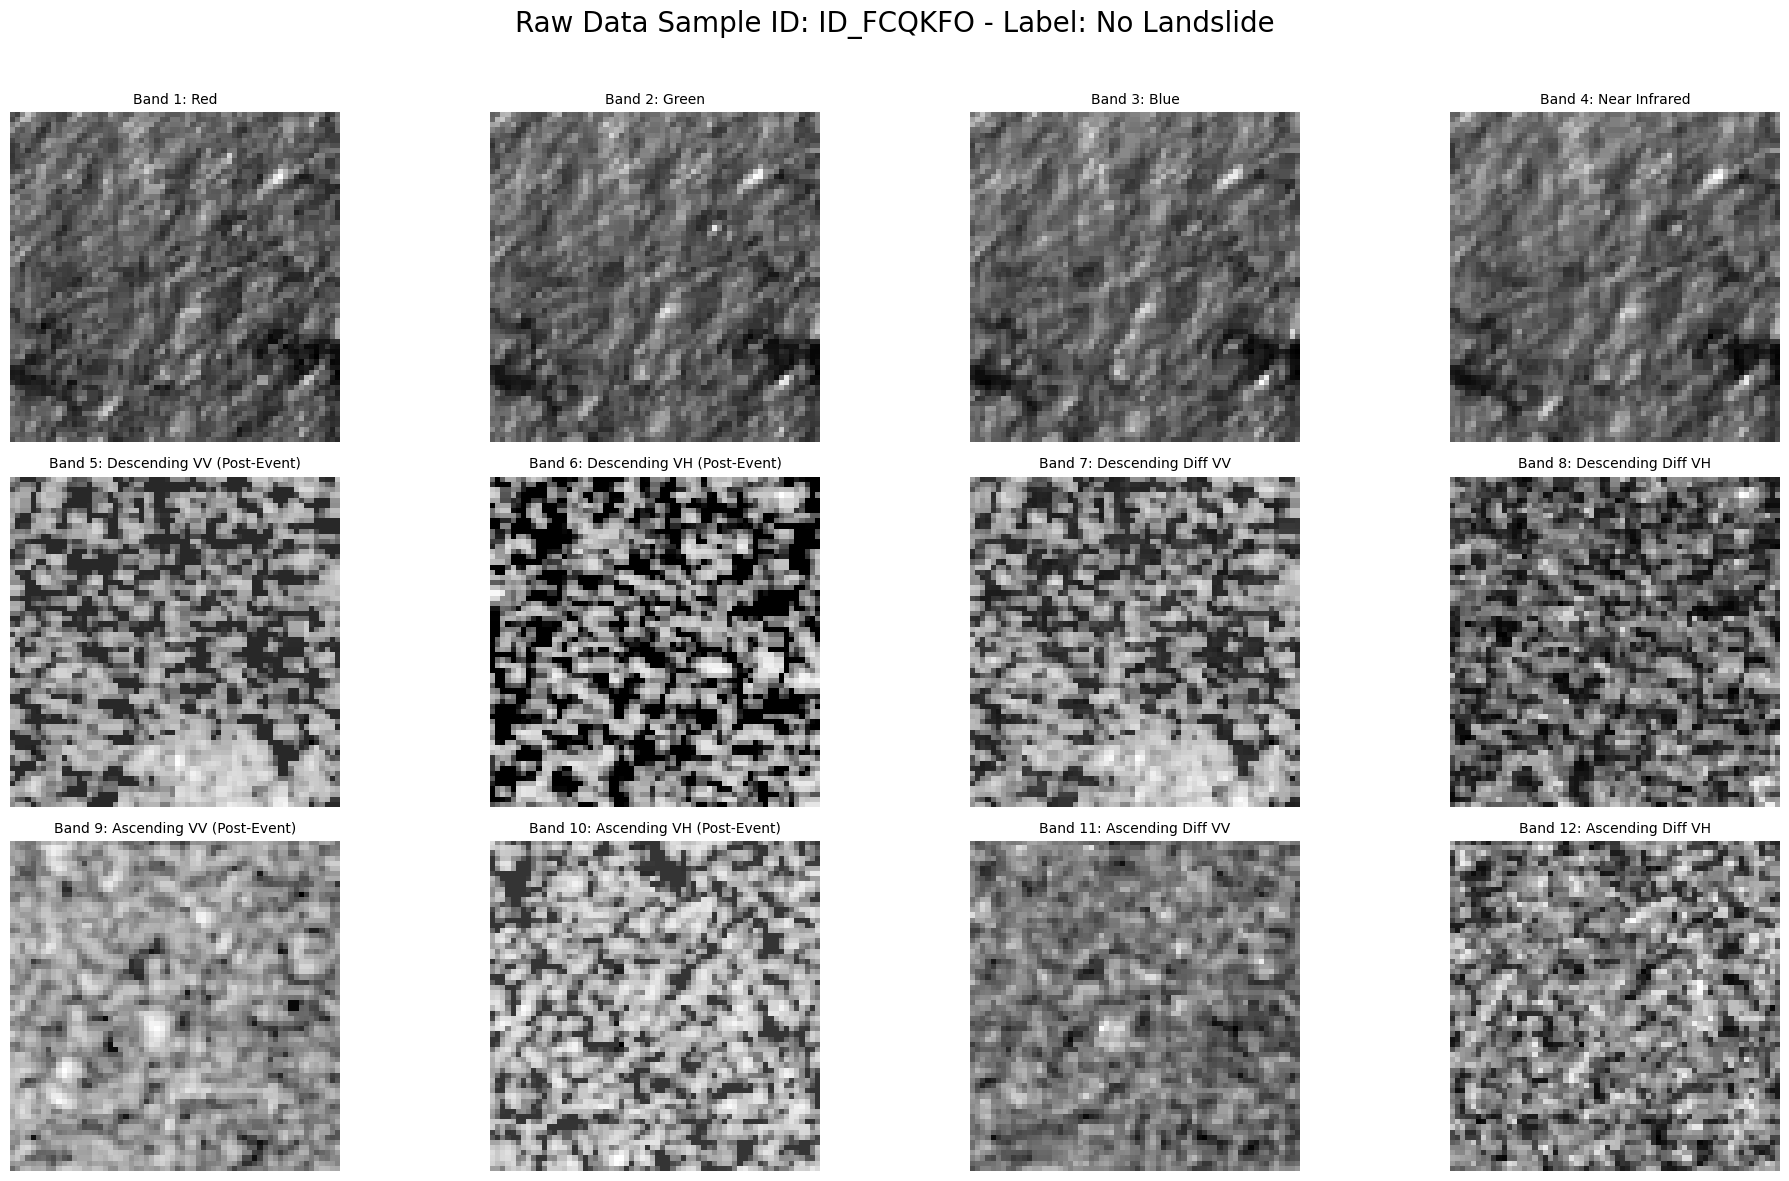

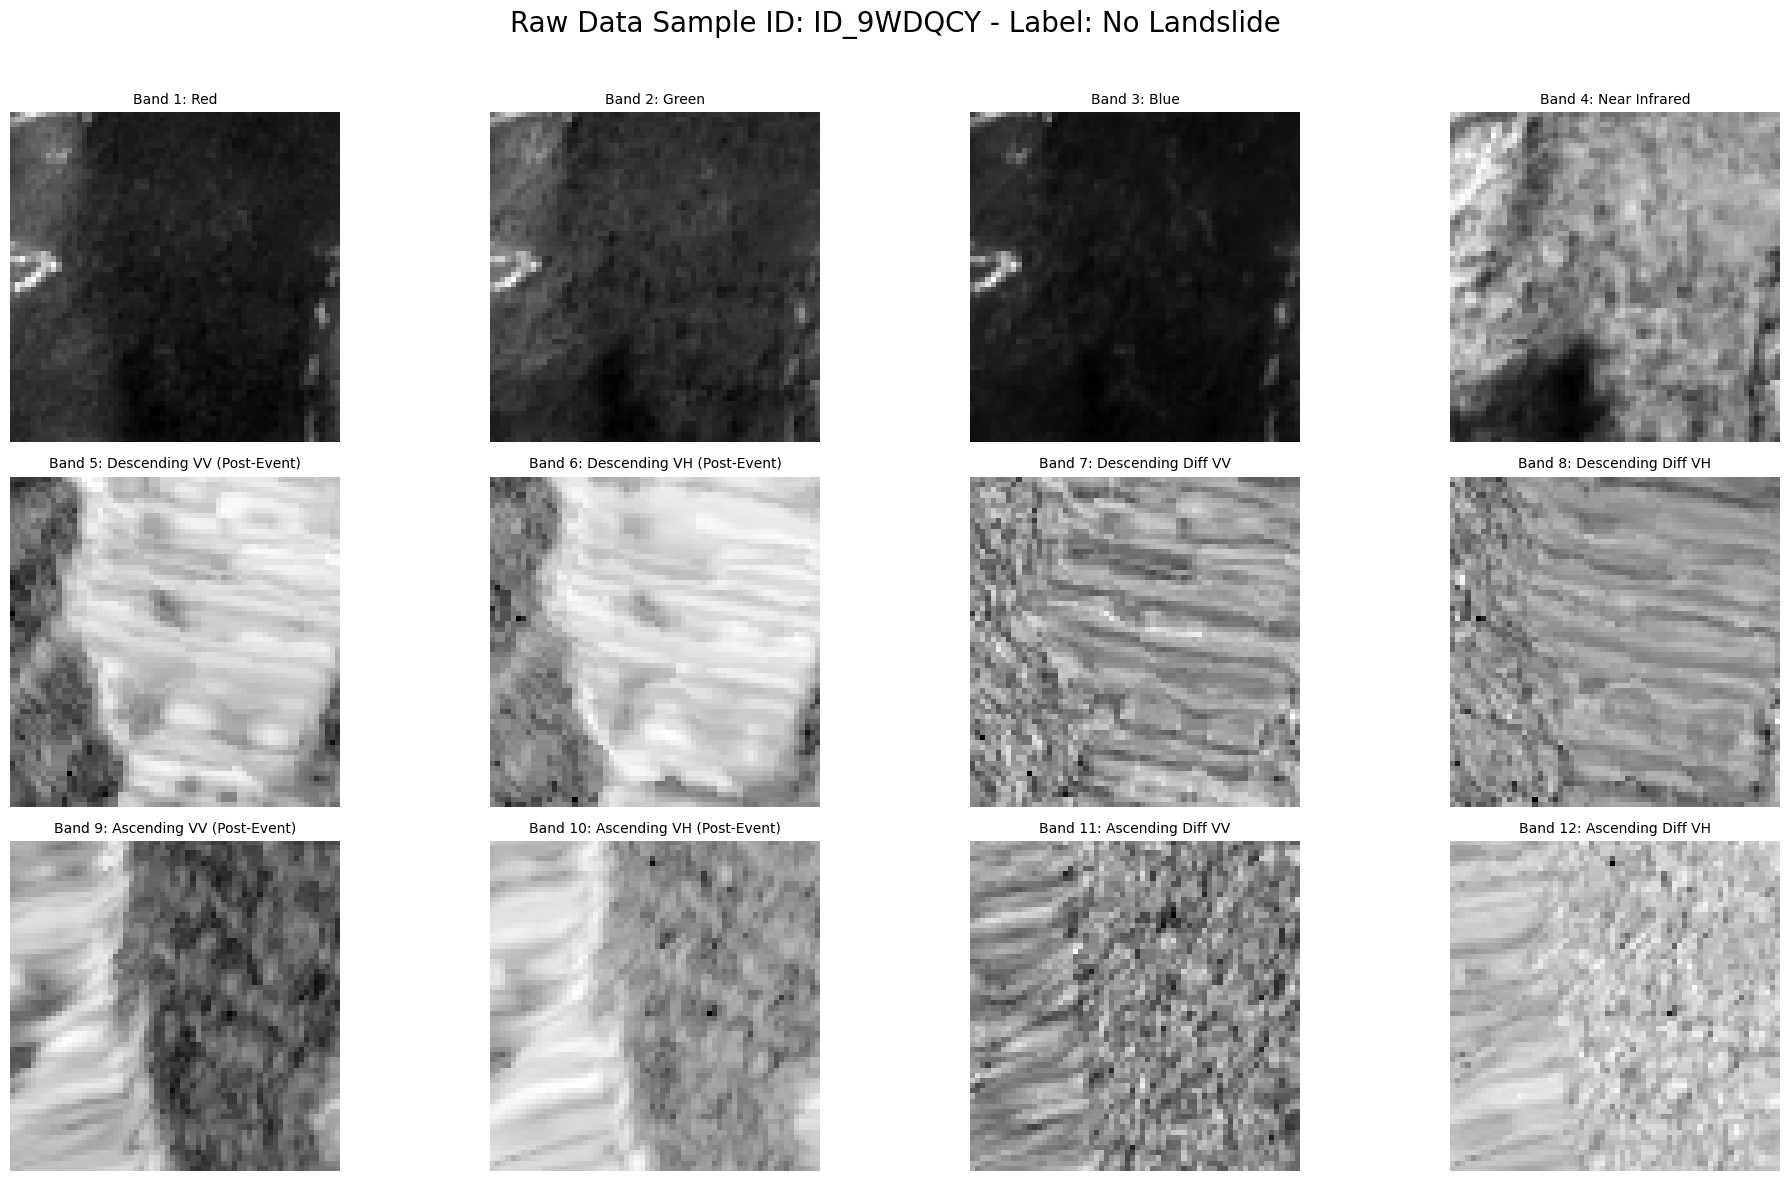

In [8]:
# INSPECTION: VISUALIZING A RAW DATA SAMPLE
print("--- Displaying raw data samples for initial inspection... ---")

# This local helper function is only used within this cell.
# It has no external dependencies.
def load_and_normalize_for_display(image_id, folder_path):
    """
    A simple, self-contained function to load one .npy file and normalize
    its bands to the 0-1 range, purely for visualization purposes.
    """
    image_path = os.path.join(folder_path, f"{image_id}.npy")
    try:
        img = np.load(image_path)
    except FileNotFoundError:
        print(f"ERROR: Could not find image file at {image_path}")
        return None, None # Return None if the file doesn't exist

    # Normalize each band individually to the 0-1 range for clear plotting.
    # A small epsilon (1e-6) is added to prevent division by zero if a band is blank.
    min_vals = img.min(axis=(0, 1), keepdims=True)
    max_vals = img.max(axis=(0, 1), keepdims=True)
    img_normalized = (img - min_vals) / (max_vals - min_vals + 1e-6)
    
    # Get the corresponding label from the main DataFrame
    label = full_train_df[full_train_df['ID'] == image_id]['label'].values[0]
    
    return img_normalized, label

# --- Plot a Couple of Random Examples ---
# This only depends on variables defined at the top of the notebook.
band_descriptions = [
    "Red", "Green", "Blue", "Near Infrared",
    "Descending VV (Post-Event)", "Descending VH (Post-Event)",
    "Descending Diff VV", "Descending Diff VH",
    "Ascending VV (Post-Event)", "Ascending VH (Post-Event)",
    "Ascending Diff VV", "Ascending Diff VH"
]

# Get two random IDs from the training dataframe
example_ids = full_train_df.sample(2)['ID'].values

for image_id in example_ids:
    # Use our simple, local function to get the data
    normalized_image, label_value = load_and_normalize_for_display(image_id, TRAIN_NPY_PATH)

    # Proceed only if the image was loaded successfully
    if normalized_image is not None:
        label_text = "Landslide" if label_value == 1 else "No Landslide"

        fig, axes = plt.subplots(3, 4, figsize=(20, 12))
        fig.suptitle(f"Raw Data Sample ID: {image_id} - Label: {label_text}", fontsize=20)

        for band in range(12):
            row = band // 4
            col = band % 4
            ax = axes[row, col]
            # Use a grayscale colormap to represent single-band intensity
            ax.imshow(normalized_image[:, :, band], cmap='gray')
            ax.set_title(f"Band {band + 1}: {band_descriptions[band]}", fontsize=10)
            ax.axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

### **Observation**
- For the human eye it is extremely difficult to to identify a landslide from a non-landslide just by looking at these 12 bands individually. This diffuculty in visual interpretation is exactly the reason why a machine learning model is needed.
- Thus the success of this project does not depend on creating visually obvious features but on building a model capable of learning the subtle, multi-dimensional patterns that aren't apparent to the human eye

# **DATA PREPARATION**


- In this section, the raw data is transformed into a clean, structured and model-ready format. This will involve splitting the data for training and validating. 

In [9]:
# Train validation split
from sklearn.model_selection import train_test_split

print("Creating the master Train/Validation Split")

# Determine the indices for our working dataset (either full or a sample)
if Config.USE_FULL_DATASET:
    print("Using full dataset.")
    # The indices are simply all the indices from the full dataset
    working_indices = np.arange(len(full_train_df))
else:
    print(f"Creating a {Config.SAMPLE_FRACTION*100}% stratified subsample.")
    # Perform a stratified split on the LABELS to get a representative subsample of indices
    _, working_indices = train_test_split(
        np.arange(len(full_train_df)),
        test_size=Config.SAMPLE_FRACTION,
        shuffle=True,
        stratify=full_train_df['label'].values,
        random_state=Config.SEED
    )

print(f"Working with {len(working_indices)} total samples.")

# Split these indices into training and validation sets
train_indices, val_indices = train_test_split(
    working_indices,
    test_size=0.20,
    shuffle=True,
    # Stratify on the labels corresponding to our working indices
    stratify=full_train_df['label'].iloc[working_indices].values,
    random_state=Config.SEED
)

print(f"Split into {len(train_indices)} training samples and {len(val_indices)} validation samples.")

Creating the master Train/Validation Split
Creating a 50.0% stratified subsample.
Working with 3574 total samples.
Split into 2859 training samples and 715 validation samples.


## 3.1 STATISTICAL FEATURE ENGINEERING FOR TRADITIONAL MODELS

To create a strong baseline. we ;
- First prepare the data for traditional tree-based models like XGBoost and LightGBM. This will convert the raw image arrays into a tabular format by engineering statistical features.
- For each of the 12 original bands plus the engineered ones, the aggregate statistics like mean and standard deviation are calculated. By doing this we extract the important signal from the noisy spatial data into a set of tabular features

In [10]:
# ## 3.1 STATISTICAL FEATURE ENGINEERING FOR TRADITIONAL MODELS (FROM .NPY FILES)

# --- Step 1: Load data from .npy files just for this section ---
print("Loading raw .npy files into memory for tree model feature engineering...")

# Helper function to load a single image
def load_npy_image(image_id, folder_path):
    image_path = os.path.join(folder_path, f"{image_id}.npy")
    img = np.load(image_path, mmap_mode='r')
    return img.astype('float32')

# Load the training images into a temporary NumPy array
# NOTE: We use "full_train_df" to ensure this works whether you are sampling or not
X_train_npy_temp = np.array([load_npy_image(image_id, TRAIN_NPY_PATH) for image_id in full_train_df['ID']])
print(f"...loading complete. Shape of temporary training data: {X_train_npy_temp.shape}")

# --- Step 2: Perform your original statistical feature engineering ---

def extract_additional_features(img_array):
    """Calculates derived indices like NDVI and NDWI."""
    red, green, nir = img_array[..., 0], img_array[..., 1], img_array[..., 3]
    epsilon = 1e-7
    ndvi = (nir - red) / (nir + red + epsilon)
    ndwi = (green - nir) / (green + nir + epsilon)
    return np.concatenate([img_array, ndvi[..., np.newaxis], ndwi[..., np.newaxis]], axis=-1)

print("\nCalculating derived indices (like NDVI) for training data...")
X_train_with_indices = extract_additional_features(X_train_npy_temp)

def create_statistical_features_df(df, image_features_array):
    """Calculates aggregate statistics for each channel."""
    stats_df = df.copy()
    band_names = [f'band{i+1}' for i in range(12)] + ['ndvi', 'ndwi']
    # Calculate the mean brightness across RGB channels for each image
    # The input `image_features_array` contains the original 12 bands first.
    print("Adding cloud score (mean brightness) to statistical features...")
    rgb_data = image_features_array[:, :, :, :3]
    stats_df['cloud_score_brightness'] = np.mean(rgb_data, axis=(1, 2, 3))
    print(f"\nGenerating statistical features for {len(stats_df)} samples...")
    for i, name in enumerate(band_names):
        channel_data = image_features_array[:, :, :, i]
        stats_df[f'{name}_mean'] = channel_data.mean(axis=(1, 2))
        stats_df[f'{name}_std']  = channel_data.std(axis=(1, 2))
        stats_df[f'{name}_min']  = channel_data.min(axis=(1, 2))
        stats_df[f'{name}_max']  = channel_data.max(axis=(1, 2))
        stats_df[f'{name}_kurt'] = kurtosis(channel_data, axis=(1, 2), fisher=True)
        stats_df[f'{name}_skew'] = skew(channel_data, axis=(1, 2))
    print("...statistical features created successfully.")
    return stats_df

# Create the final tabular DataFrame for your tree models
training_df_stats = create_statistical_features_df(full_train_df, X_train_with_indices)

# --- Step 3: IMPORTANT - Clean up memory ---
print("\n Cleaning up temporary NumPy arrays to free up RAM...")
del X_train_npy_temp
del X_train_with_indices
import gc
gc.collect()
print(" Memory freed. Proceeding.")

# Display a preview
print("\nPreview of the training DataFrame for tree models:")
display(training_df_stats.head())



Loading raw .npy files into memory for tree model feature engineering...
...loading complete. Shape of temporary training data: (7147, 64, 64, 12)

Calculating derived indices (like NDVI) for training data...
Adding cloud score (mean brightness) to statistical features...

Generating statistical features for 7147 samples...
...statistical features created successfully.

 Cleaning up temporary NumPy arrays to free up RAM...
 Memory freed. Proceeding.

Preview of the training DataFrame for tree models:


,ID,label,cloud_score_brightness,band1_mean,band1_std,band1_min,band1_max,band1_kurt,band1_skew,band2_mean,...,ndvi_min,ndvi_max,ndvi_kurt,ndvi_skew,ndwi_mean,ndwi_std,ndwi_min,ndwi_max,ndwi_kurt,ndwi_skew
0,ID_HUD1ST,1,1616.105591,1569.305908,189.202896,1286.0,2786.0,5.343067,1.930577,1751.834229,...,0.051762,0.578009,2.067133,-1.451810,-0.402533,0.076766,-0.513693,-0.031306,2.505169,1.581910
1,ID_KGE2HY,1,1641.437866,1575.859131,233.255280,1309.0,2988.0,4.867769,2.048139,1750.446289,...,-0.044847,0.570146,1.214721,-1.396452,-0.348885,0.112248,-0.505679,0.074906,1.269663,1.417164
2,ID_VHV9BL,1,1475.925659,1396.610352,811.493347,939.0,9040.0,32.241085,5.189392,1528.299805,...,-0.068752,0.723393,-0.927661,-0.325244,-0.337329,0.150220,-1.000000,0.041941,-0.857999,0.307474
3,ID_ZT0VEJ,0,1624.411499,1589.653320,366.122314,1300.0,4244.0,12.224893,3.234218,1746.923828,...,0.118875,0.599184,1.487577,-1.212002,-0.397269,0.069903,-0.539870,-0.107788,1.487541,1.217311
4,ID_5NFXVY,0,1488.263306,1456.682617,120.247475,1317.0,2064.0,5.837114,2.370760,1595.559570,...,0.090818,0.531350,8.192582,-2.779035,-0.385836,0.070818,-0.481177,-0.061585,8.969378,2.962669


In [11]:
import plotly.express as px
import pandas as pd

print("--- Generating Mean Spectral Profile Plot ---")

# Isolate the mean values for each of the 12 original bands
mean_columns = [f'band{i+1}_mean' for i in range(12)]

# Separate the dataframe by class
landslide_df = training_df_stats[training_df_stats['label'] == 1]
no_landslide_df = training_df_stats[training_df_stats['label'] == 0]

# Calculate the average profile for each class
landslide_profile = landslide_df[mean_columns].mean()
no_landslide_profile = no_landslide_df[mean_columns].mean()

# Define clear names for the bands for better plotting
band_descriptions = [
    "1: Red", "2: Green", "3: Blue", "4: NIR",
    "5: Desc VV (Post)", "6: Desc VH (Post)",
    "7: Desc VV Change", "8: Desc VH Change",
    "9: Asc VV (Post)", "10: Asc VH (Post)",
    "11: Asc VV Change", "12: Asc VH Change"
]

# Create a new dataframe suitable for plotting
plot_df = pd.DataFrame({
    'Band': band_descriptions * 2,
    'Average Mean Value': pd.concat([landslide_profile, no_landslide_profile]),
    'Class': ['Landslide'] * 12 + ['No Landslide'] * 12
})

# Create the interactive line plot
fig = px.line(
    plot_df,
    x='Band',
    y='Average Mean Value',
    color='Class',
    markers=True,
    title="Mean Spectral Profile: Landslide vs. No Landslide",
    labels={"Average Mean Value": "Average of Mean Pixel Values Across All Images"},
    template='plotly_white',
    color_discrete_map={'Landslide': 'salmon', 'No Landslide': 'teal'}
)

fig.update_layout(
    xaxis_title="Data Bands",
    yaxis_title="Average Pixel Value",
    legend_title="Image Class",
    font=dict(size=12)
)

fig.show()

--- Generating Mean Spectral Profile Plot ---


--- Generating Mean Spectral Profile Plot (Matplotlib) ---


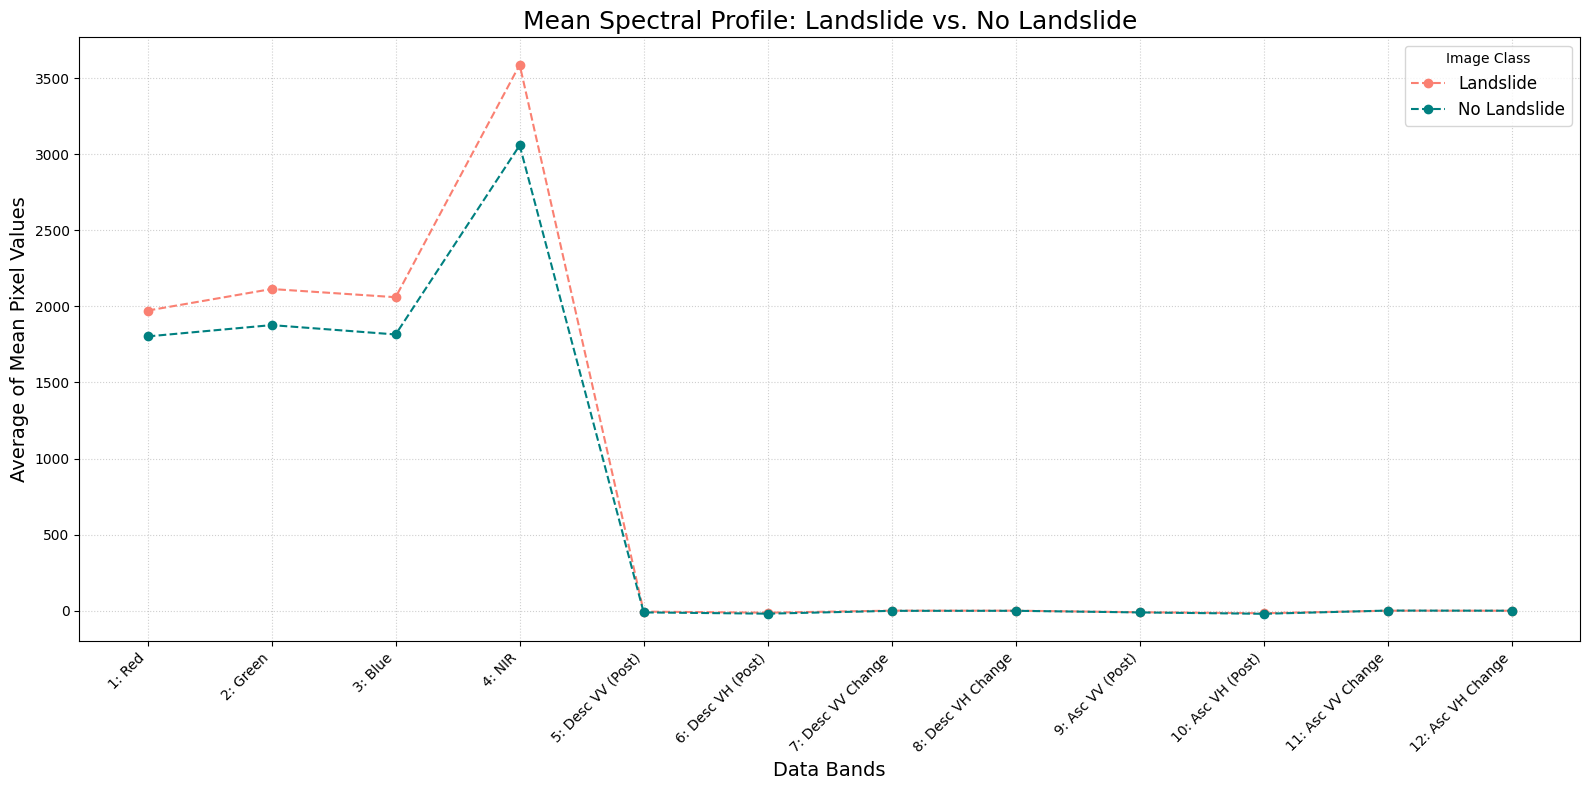

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

print("--- Generating Mean Spectral Profile Plot (Matplotlib) ---")

# Isolate the mean values for each of the 12 original bands
mean_columns = [f'band{i+1}_mean' for i in range(12)]

# Separate the dataframe by class
landslide_df = training_df_stats[training_df_stats['label'] == 1]
no_landslide_df = training_df_stats[training_df_stats['label'] == 0]

# Calculate the average profile for each class
landslide_profile = landslide_df[mean_columns].mean()
no_landslide_profile = no_landslide_df[mean_columns].mean()

# Define clear names for the bands for better plotting
band_descriptions = [
    "1: Red", "2: Green", "3: Blue", "4: NIR",
    "5: Desc VV (Post)", "6: Desc VH (Post)",
    "7: Desc VV Change", "8: Desc VH Change",
    "9: Asc VV (Post)", "10: Asc VH (Post)",
    "11: Asc VV Change", "12: Asc VH Change"
]

# --- Create the plot using Matplotlib ---
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the data for each class
ax.plot(band_descriptions, landslide_profile, marker='o', linestyle='--', color='salmon', label='Landslide')
ax.plot(band_descriptions, no_landslide_profile, marker='o', linestyle='--', color='teal', label='No Landslide')

# Add titles and labels for clarity
ax.set_title("Mean Spectral Profile: Landslide vs. No Landslide", fontsize=18)
ax.set_xlabel("Data Bands", fontsize=14)
ax.set_ylabel("Average of Mean Pixel Values", fontsize=14)

# Improve readability
plt.xticks(rotation=45, ha="right") # Rotate x-axis labels to prevent overlap
ax.legend(title="Image Class", fontsize=12)
ax.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout() # Adjust layout to make room for labels

# Display the plot
plt.show()

In [43]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("--- Generating PCA Plot to Visualize Feature Separability ---")

# --- 1. Prepare the Data ---
# We can use the same sampled data as the t-SNE plot for a fair comparison.
sample_fraction = 0.5 
plot_data = training_df_stats.sample(frac=sample_fraction, random_state=42, replace=False)

# Separate features from the labels and IDs
features = plot_data.drop(columns=['ID', 'label'])
labels = plot_data['label']

print(f"Running PCA on {len(plot_data)} samples...")

# --- 2. Standardize the Features ---
# PCA is highly sensitive to feature scaling, so this step is essential.
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# --- 3. Apply PCA ---
# This will project the 85 features down to 2 principal components.
pca = PCA(n_components=2, random_state=42)
pca_results = pca.fit_transform(features_scaled)

print("...PCA calculation complete.")

# --- 4. Create the Plot ---
# Add the PCA results to a new DataFrame for plotting
plot_df_pca = pd.DataFrame({
    'PC1': pca_results[:,0],
    'PC2': pca_results[:,1],
    'label': labels.map({0: 'No Landslide', 1: 'Landslide'}) # Use descriptive names
})

# Create the interactive scatter plot
fig = px.scatter(
    plot_df_pca,
    x='PC1',
    y='PC2',
    color='label',
    title="PCA Visualization of Engineered Features",
    labels={
        "PC1": "Principal Component 1",
        "PC2": "Principal Component 2"
    },
    template='plotly_white',
    color_discrete_map={'Landslide': 'salmon', 'No Landslide': 'teal'}
)

fig.update_layout(
    legend_title="Image Class",
    font=dict(size=12)
)

fig.update_traces(marker=dict(size=5, opacity=0.7))

fig.show()

--- Generating PCA Plot to Visualize Feature Separability ---
Running PCA on 3574 samples...
...PCA calculation complete.


In [46]:
import plotly.express as px
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

print("--- Generating t-SNE Plot to Visualize Feature Separability ---")

# --- 1. Prepare the Data ---
# For performance, t-SNE is often run on a sample of the data. 
# We'll use a stratified sample to ensure it's representative.
sample_fraction = 0.5 # Use 50% of the data for the plot
plot_data = training_df_stats.sample(frac=sample_fraction, random_state=42, replace=False)

# Separate features from the labels and IDs
features = plot_data.drop(columns=['ID', 'label'])
labels = plot_data['label']

print(f"Running t-SNE on {len(plot_data)} samples...")

# --- 2. Standardize the Features ---
# t-SNE is sensitive to the scale of features, so standardization is crucial.
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# --- 3. Apply t-SNE ---
# This will project the 85 features down to 2 dimensions for plotting.
tsne = TSNE(
    n_components=2,     # We want a 2D plot
    perplexity=30,      # A common starting point for this parameter
    random_state=42,
    n_iter=1000
)
tsne_results = tsne.fit_transform(features_scaled)

print("...t-SNE calculation complete.")

# --- 4. Create the Plot ---
# Add the t-SNE results to a new DataFrame for plotting
plot_df_tsne = pd.DataFrame({
    'tsne-1': tsne_results[:,0],
    'tsne-2': tsne_results[:,1],
    'label': labels.map({0: 'No Landslide', 1: 'Landslide'}) # Use descriptive names
})

# Create the interactive scatter plot
fig = px.scatter(
    plot_df_tsne,
    x='tsne-1',
    y='tsne-2',
    color='label',
    title="t-SNE Visualization of Engineered Features",
    labels={
        "tsne-1": "t-SNE Dimension 1",
        "tsne-2": "t-SNE Dimension 2"
    },
    template='plotly_white',
    color_discrete_map={'Landslide': 'salmon', 'No Landslide': 'teal'}
)

fig.update_layout(
    legend_title="Image Class",
    font=dict(size=12)
)

fig.update_traces(marker=dict(size=5, opacity=0.7))

fig.show()

--- Generating t-SNE Plot to Visualize Feature Separability ---
Running t-SNE on 3574 samples...
...t-SNE calculation complete.


# 3. **Data Preparation**

## 3.1 Feature Engineering & Global Statistics Calculation

 The goal here is to transform the raw data into a format that is optimized for our models.

 - The `calculate_global_stats` function is to create more predictive features form the raw image bands. These domain-specific features like the Normalized Difference Vegetation Index(NDVI) and the magnitude of change in the SAR signals, are designed to provide stronger signals to the moedl rather than using the raw pixels alone.
 - The function also calculates the global minimum and maximum values from all features. This is essential for the next step of normalization

### Engineered Features

Four new features from the original 12-band imagery will be created which are:

1. **NDVI (Normalized Difference Vegetation Index)**  
   Measures vegetation health and density. Higher NDVI values indicate more vigorous vegetation.  

   $$
   \text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red} + \epsilon}
   $$

2. **NDWI (Normalized Difference Water Index)**  
   Enhances water-related features, useful for detecting water bodies and moisture content.  

   $$
   \text{NDWI} = \frac{\text{Green} - \text{NIR}}{\text{Green} + \text{NIR} + \epsilon}
   $$

3. **VV/VH Ratio (Descending pass)**  
   Captures surface scattering properties from the radar descending orbit. Useful for distinguishing vegetation, bare soil, and urban areas.  

   $$
   \text{Ratio}_{\text{desc}} = \frac{\text{VV}_{\text{desc}}}{\text{VH}_{\text{desc}} + \epsilon}
   $$

4. **VV/VH Ratio (Ascending pass)**  
   Same as above, but from the ascending orbit to provide complementary radar perspective.  

   $$
   \text{Ratio}_{\text{asc}} = \frac{\text{VV}_{\text{asc}}}{\text{VH}_{\text{asc}} + \epsilon}
   $$

---

**Final Output:**  
- **Original channels:** 12  
- **New engineered features:** 4  
- **Total channels:** 16  
- Shape: **(batch, H, W, 16)**

In [13]:
# FEATURE ENGINEERING & STATS CALCULATION

def calculate_global_stats(dataset):
    """
    Iterates through a tf.data.Dataset in batches to find global min/max 
    values for all potential engineered features using NumPy, while maintaining clear organization.
    """
    print("Calculating global statistics for ALL features by processing in batches...")
    
    # Dictionaries to track stats for the original 12 bands
    batch_mins_raw = {f'band_{i+1}': [] for i in range(12)}
    batch_maxes_raw = {f'band_{i+1}': [] for i in range(12)}

    # Dictionaries for engineered features
    batch_mins = {key: [] for key in ['desc_mag', 'asc_mag', 'desc_ratio_diff', 'asc_ratio_diff', 'ndvi_diff', 'ndvi_post', 'savi_diff', 'ndwi_diff', 'brightness']}
    batch_maxes = {key: [] for key in ['desc_mag', 'asc_mag', 'desc_ratio_diff', 'asc_ratio_diff', 'ndvi_diff', 'ndvi_post', 'savi_diff', 'ndwi_diff', 'brightness']}

    # Iterate through the dataset batch by batch
    for image_batch_np in dataset.as_numpy_iterator():
        epsilon = 1e-7

        # ==============================================================================
        #       # NEW: Calculate stats for the ORIGINAL 12 BANDS
        # ==============================================================================
        for i in range(12):
            batch_mins_raw[f'band_{i+1}'].append(image_batch_np[..., i].min())
            batch_maxes_raw[f'band_{i+1}'].append(image_batch_np[..., i].max())

        # ==============================================================================
        #       # Group 1: Cloud Score (Brightness)
        # ==============================================================================
        rgb_bands_batch = image_batch_np[..., :3]
        mean_brightness_per_image = np.mean(rgb_bands_batch, axis=(1, 2, 3))
        batch_mins['brightness'].append(mean_brightness_per_image.min())
        batch_maxes['brightness'].append(mean_brightness_per_image.max())

        # ==============================================================================
        #       # Group 2(a & b) Descending & Ascending Change Magnitude
        # ==============================================================================
        desc_mag = np.sqrt(np.square(image_batch_np[..., 6]) + np.square(image_batch_np[..., 7]))
        asc_mag = np.sqrt(np.square(image_batch_np[..., 10]) + np.square(image_batch_np[..., 11]))
        
        # ==============================================================================
        #       # Group 2(a) Descending VV Ratio
        # ==============================================================================
        desc_vv_post, desc_vh_post = image_batch_np[..., 4], image_batch_np[..., 5]
        desc_vv_pre = desc_vv_post - image_batch_np[..., 6]
        desc_vh_pre = desc_vh_post - image_batch_np[..., 7]
        desc_ratio_diff = (desc_vv_post / np.maximum(desc_vh_post, 1.0)) - (desc_vv_pre / np.maximum(desc_vh_pre, 1.0))
        
        # ==============================================================================
        #       # Group 2(b) Ascending VV Ratio 
        # ==============================================================================
        asc_vv_post, asc_vh_post = image_batch_np[..., 8], image_batch_np[..., 9]
        asc_vv_pre = asc_vv_post - image_batch_np[..., 10]
        asc_vh_pre = asc_vh_post - image_batch_np[..., 11]
        asc_ratio_diff = (asc_vv_post / np.maximum(asc_vh_post, 1.0)) - (asc_vv_pre / np.maximum(asc_vh_pre, 1.0))
      
        # ==============================================================================
        #       # Group 3 (a) Calculate NDVI Difference
        # ==============================================================================
        red_post, nir_post = image_batch_np[..., 0], image_batch_np[..., 3]
        proxy_change = (image_batch_np[..., 6] + image_batch_np[..., 7]) / 2.0
        red_pre, nir_pre = red_post - proxy_change, nir_post - proxy_change
        
        ndvi_post = (nir_post - red_post) / (nir_post + red_post + epsilon)
        ndvi_pre = (nir_pre - red_pre) / (nir_pre + red_pre + epsilon)
        ndvi_diff = ndvi_post - ndvi_pre
        
        # ==============================================================================
        #       # Group 3 (b) Calculate SAVI Difference
        # ==============================================================================
        L = 0.5
        savi_post = ((nir_post - red_post) / (nir_post + red_post + L)) * (1.0 + L)
        savi_pre = ((nir_pre - red_pre) / (nir_pre + red_pre + L)) * (1.0 + L)
        savi_diff = savi_post - savi_pre

        # ==============================================================================
        #       # Group 4 Calculate NDWI Difference 
        # ==============================================================================
        green_post = image_batch_np[..., 1]
        green_pre = green_post - proxy_change
        ndwi_post = (green_post - nir_post) / (green_post + nir_post + epsilon)
        ndwi_pre = (green_pre - nir_pre) / (green_pre + nir_pre + epsilon)
        ndwi_diff = ndwi_post - ndwi_pre
        
        # Store the min/max of the engineered features FOR THIS BATCH
        features = {'desc_mag': desc_mag, 'asc_mag': asc_mag, 'desc_ratio_diff': desc_ratio_diff, 
                    'asc_ratio_diff': asc_ratio_diff, 'ndvi_diff': ndvi_diff, 'ndvi_post': ndvi_post, 
                    'savi_diff': savi_diff, 'ndwi_diff': ndwi_diff}
        
        for key, data in features.items():
            batch_mins[key].append(data.min())
            batch_maxes[key].append(data.max())

    # Now, find the true global min/max by looking across all the batch results for engineered features
    stats = {
        'desc_mag_min': min(batch_mins['desc_mag']), 'desc_mag_max': max(batch_maxes['desc_mag']),
        'asc_mag_min': min(batch_mins['asc_mag']), 'asc_mag_max': max(batch_maxes['asc_mag']),
        'desc_ratio_diff_min': min(batch_mins['desc_ratio_diff']), 'desc_ratio_diff_max': max(batch_maxes['desc_ratio_diff']),
        'asc_ratio_diff_min': min(batch_mins['asc_ratio_diff']), 'asc_ratio_diff_max': max(batch_maxes['asc_ratio_diff']),
        'ndvi_diff_min': min(batch_mins['ndvi_diff']), 'ndvi_diff_max': max(batch_maxes['ndvi_diff']),
        'ndvi_post_min': min(batch_mins['ndvi_post']), 'ndvi_post_max': max(batch_maxes['ndvi_post']),
        'savi_diff_min': min(batch_mins['savi_diff']), 'savi_diff_max': max(batch_maxes['savi_diff']),
        'ndwi_diff_min': min(batch_mins['ndwi_diff']), 'ndwi_diff_max': max(batch_maxes['ndwi_diff']),
        'brightness_min': min(batch_mins['brightness']),
        'brightness_max': max(batch_maxes['brightness']),
    }
    
    print("Global statistics calculation complete.")
    
    # Compile the stats for the original raw bands
    stats_raw = {f'band_{i+1}_min': min(batch_mins_raw[f'band_{i+1}']) for i in range(12)}
    stats_raw.update({f'band_{i+1}_max': max(batch_maxes_raw[f'band_{i+1}']) for i in range(12)})
    
    return stats, stats_raw # Return both dictionaries

# This small helper function is just for parsing the raw images for stats calculation
def parse_for_stats(example_proto):
    feature_description = {'image': tf.io.FixedLenFeature([], tf.string), 'id': tf.io.FixedLenFeature([], tf.string), 'label': tf.io.FixedLenFeature([], tf.int64)}
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float64)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [*Config.IMAGE_SIZE, 12])
    return image

print("Preparing data for streaming statistics calculation...")

# Create a dataset from the full training data for stats calculation.
full_tf_dataset_for_stats = tf.data.TFRecordDataset(TRAIN_TFRECORD_PATH)
stats_dataset_parsed = full_tf_dataset_for_stats.map(parse_for_stats, num_parallel_calls=tf.data.AUTOTUNE).batch(256)

# --- EXECUTE THE CALCULATION & CAPTURE BOTH OUTPUTS ---
global_stats, global_stats_raw = calculate_global_stats(stats_dataset_parsed)

# --- DISPLAY THE RESULTS SEPARATELY ---
print("\n--- Global Min/Max for Original 12 Bands ---")
band_names = [
    "Red", "Green", "Blue", "NIR",
    "Desc VV (Post)", "Desc VH (Post)", "Desc VV Change", "Desc VH Change",
    "Asc VV (Post)", "Asc VH (Post)", "Asc VV Change", "Asc VH Change"
]
stats_summary_list = []
for i, name in enumerate(band_names):
    stats_summary_list.append({
        "Band Name": name,
        "Min Value": global_stats_raw[f'band_{i+1}_min'],
        "Max Value": global_stats_raw[f'band_{i+1}_max']
    })
display(pd.DataFrame(stats_summary_list))


print("\n Global Min/Max for Engineered Features (for normalization)")
eng_stats_list = []
# Create a list of the base names for our engineered features
engineered_feature_names = ['desc_mag', 'asc_mag', 'desc_ratio_diff', 'asc_ratio_diff', 
                            'ndvi_diff', 'ndvi_post', 'savi_diff', 'ndwi_diff', 'brightness']

for name in engineered_feature_names:
    eng_stats_list.append({
        "Engineered Feature": name,
        "Min Value": global_stats[f'{name}_min'],
        "Max Value": global_stats[f'{name}_max']
    })

display(pd.DataFrame(eng_stats_list))

Preparing data for streaming statistics calculation...
Calculating global statistics for ALL features by processing in batches...
Global statistics calculation complete.

--- Global Min/Max for Original 12 Bands ---


,Band Name,Min Value,Max Value
0,Red,0.000000,20944.000000
1,Green,0.000000,19744.000000
2,Blue,0.000000,18816.000000
3,NIR,0.000000,17600.000000
4,Desc VV (Post),-56.998489,25.324352
5,Desc VH (Post),-65.662262,16.366713
6,Desc VV Change,-41.327717,26.209181
7,Desc VH Change,-36.699978,32.632099
8,Asc VV (Post),-58.200050,33.060013
9,Asc VH (Post),-62.981258,23.875465



 Global Min/Max for Engineered Features (for normalization)


,Engineered Feature,Min Value,Max Value
0,desc_mag,0.000412,45.947479
1,asc_mag,0.000049,50.266449
2,desc_ratio_diff,-41.327717,26.209181
3,asc_ratio_diff,-35.428696,35.044502
4,ndvi_diff,-0.033887,1.781672
5,ndvi_post,-1.000000,1.000000
6,savi_diff,-0.050799,2.924784
7,ndwi_diff,-1.781672,0.039042
8,brightness,941.318176,11457.124023


## 3.2 Define TensorFlow Feature Engineering Function
- This cell is used to create the domain specific features. The function takes the original 12-channel image as input and outputs a new 15-channel. The result is what our model will use for prediction.
- The `@tf.function` decorator, enables the Python code to be compiled into a TensorFlow graph which allows all the mathematical operations—such as calculating NDVI, SAR change magnitude, and the cloud score,to be executed  on the GPU.

In [14]:
# FEATURE ENGINEERING FUNCTION

@tf.function # python code is compiled into
def engineer_features(image, stats):
    """
    Applies feature engineering. Calculates RAW engineered features and a
    NORMALIZED (0-1) cloud score channel.
    """
    epsilon = tf.keras.backend.epsilon() 
    
    # --- ACTIVE FEATURES (RAW VALUES) ---
    asc_mag = tf.sqrt(tf.square(image[..., 10]) + tf.square(image[..., 11]) + epsilon)
    asc_mag = tf.expand_dims(asc_mag, axis=-1)

    red_post, nir_post = image[..., 0], image[..., 3]
    proxy_change = (image[..., 6] + image[..., 7]) / 2.0
    red_pre, nir_pre = red_post - proxy_change, nir_post - proxy_change
    ndvi_post = (nir_post - red_post) / (nir_post + red_post + epsilon)
    ndvi_pre  = (nir_pre - red_pre) / (nir_pre + red_pre + epsilon)
    ndvi_diff = tf.expand_dims(ndvi_post - ndvi_pre, axis=-1)
    
    # --- CLOUD SCORE (NORMALIZED to 0-1) ---
    red_band, green_band, blue_band = image[..., 0], image[..., 1], image[..., 2]
    pixel_wise_avg = (red_band + green_band + blue_band) / 3.0
    avg_brightness = tf.reduce_mean(pixel_wise_avg)
    norm_brightness = (avg_brightness - stats['brightness_min']) / (stats['brightness_max'] - stats['brightness_min'] + epsilon)
    cloud_channel = tf.fill(dims=tf.shape(red_band), value=norm_brightness)
    cloud_channel = tf.expand_dims(cloud_channel, axis=-1)
    # --- END OF FIX ---
    # ==============================================================================
    #       # --- INACTIVE FEATURES (Code is here if you want to test them later) ---
    # ==============================================================================
    
    # # Feature: Descending Change Magnitude
    desc_diff_vv = image[..., 6]
    desc_diff_vh = image[..., 7]
    desc_mag = tf.sqrt(tf.square(desc_diff_vv) + tf.square(desc_diff_vh) + epsilon)
    desc_mag = tf.expand_dims(desc_mag, axis=-1)

    # # Feature: Descending VV Ratio Difference
    # desc_vv_post, desc_vh_post = image[..., 4], image[..., 5]
    # desc_vv_pre = desc_vv_post - image[..., 6]
    # desc_vh_pre = desc_vh_post - image[..., 7]
    # denominator_floor = tf.constant(1.0, dtype=tf.float32)
    # ratio_post = desc_vv_post / tf.maximum(desc_vh_post, denominator_floor)
    # ratio_pre  = desc_vv_pre  / tf.maximum(desc_vh_pre,  denominator_floor)
    # desc_ratio_diff = tf.expand_dims(ratio_post - ratio_pre, axis=-1)

    # # Feature: Ascending VV Ratio Difference
    # asc_vv_post, asc_vh_post = image[..., 8], image[..., 9]
    # asc_vv_pre = asc_vv_post - image[..., 10]
    # asc_vh_pre = asc_vh_post - image[..., 11]
    # ratio_post_asc = asc_vv_post / tf.maximum(asc_vh_post, denominator_floor)
    # ratio_pre_asc  = asc_vv_pre  / tf.maximum(asc_vh_pre,  denominator_floor)
    # asc_ratio_diff = tf.expand_dims(ratio_post_asc - ratio_pre_asc, axis=-1)

    # # Feature: NDVI Post-Event
    # ndvi_post_expanded = tf.expand_dims(ndvi_post, axis=-1)
    
    # # Feature: SAVI Difference
    # L = tf.constant(0.5, dtype=tf.float32)
    # savi_post = ((nir_post - red_post) / (nir_post + red_post + L)) * (1.0 + L)
    # savi_pre  = ((nir_pre - red_pre) / (nir_pre + red_pre + L)) * (1.0 + L)
    # savi_diff = tf.expand_dims(savi_post - savi_pre, axis=-1)

    # # Feature: NDWI Difference
    # green_post = image[..., 1]
    # green_pre = green_post - proxy_optical_change
    # ndwi_post = (green_post - nir_post) / (green_post + nir_post + epsilon)
    # ndwi_pre  = (green_pre - nir_pre) / (green_pre + nir_pre + epsilon)
    # ndwi_diff = tf.expand_dims(ndwi_post - ndwi_pre, axis=-1)
    
    # ==============================================================================
    #       # Final Concatenation (12 original + 3 active engineered = 15 total)
    # ==============================================================================
    final_image = tf.concat([
        image,
        desc_mag,
        ndvi_diff,
        cloud_channel
    ], axis=-1)
    
    return final_image

print("Engineer_features` function defined.")

Engineer_features` function defined.


# 6. Define the High-Performance tf.data Pipeline Function

1. A Reusable Factory: We now have one function, build_dataset, that can create a dataset for training, validation, or testing, just by changing the arguments.
2. CPU/GPU Division of Labor: It isolates the single non-TensorFlow operation (np.load) into a tf.py_function and ensures all the heavy mathematical work (resizing, NDVI, augmentations) is defined with tf.* operations, allowing them to be offloaded to the GPU.
3. Performance Optimization: It includes .shuffle(), .batch(), and the critical .prefetch() methods to ensure a smooth, fast, and continuous stream of data to the accelerator.

## 3.3 Define the Data Processing Function

This cell creates the central function of `tf.data` pipeline. The aim is to define a single, function that handles all the necessary steps to get the raw data ready for the neural network.

The `get_parse_function` takes our global statistics and uses them to build a `parse_tfrecord_function`. This inner function will be applied to every sample in our dataset, and performs the following:

1.  **Parse:** It reads and decodes a single data record from the TFRecord file.
2.  **Engineer Features:** It immediately applies the `engineer_features` function to expand the image from 12 to 15 channels, adding our custom features.
3.  **Scale Values:** It normalizes the feature channels to a common scale. It **scales** only the first 14 channels, leaving the already-normalized cloud score channel untouched.
4.  **Resize Image:** It resizes the processed 15-channel image to the final `(224, 224)` dimensions required by our CNN model.

This approach is efficient because it bundles all the preparation steps into a single function that TensorFlow can optimize and run quickly on the GPU.

In [15]:
# This is the factory function for the main data pipeline
def get_parse_function(stats):
    stats_tensor = {k: tf.constant(v, dtype=tf.float32) for k, v in stats.items()}
    
    @tf.function
    def parse_tfrecord_function(example_proto):
        # ... (parsing logic) ...
        feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'id': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.int64),
        }
        parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float64)
        image = tf.cast(image, tf.float32)
        image = tf.reshape(image, [*Config.IMAGE_SIZE, 12])
        
        # This function returns the 15-channel tensor
        image_with_features = engineer_features(image, stats_tensor)
        
        # The number of feature channels to be scaled is always one less than the total.
        num_feature_channels = Config.N_CHANNELS - 1
        
        # Select all channels EXCEPT the last one (the cloud channel) using the dynamic variable.
        feature_channels = image_with_features[..., :num_feature_channels]
        
        # Select only the very last channel (the cloud channel) using the dynamic variable.
        cloud_channel = image_with_features[..., num_feature_channels:]

        # Scale ONLY the 14 feature channels
        scaled_feature_channels = feature_channels / 255.0

        # Recombine with the UNTOUCHED (0 to 1) cloud channel
        final_processed_image = tf.concat([scaled_feature_channels, cloud_channel], axis=-1)
        
        
        
        image = tf.image.resize(final_processed_image, Config.TARGET_SIZE, method='bilinear')
        
        image = tf.ensure_shape(image, [*Config.TARGET_SIZE, Config.N_CHANNELS])
        label = tf.cast(parsed_features['label'], tf.float32)
        label = tf.reshape(label, (1,))
        
        return image, label
        
    return parse_tfrecord_function

# This line MUST be here to create the global variable for other cells to use
# It is now created with the correct global_stats dictionary.
parse_function_with_stats = get_parse_function(global_stats)
print("Global `parse_function created successfully.")

Global `parse_function created successfully.


# 7. DEFINE THE `build_dataset` FUNCTION
Read TFRecords and also handles the data augmentation.

## 3.4 Constructing the Final Data Pipeline

Creating the `build_dataset` function. Its purpose is to take a raw dataset and apply the final sequence of operations to make it ready for model training or evaluation.

The functions performed are:

*   **Parsing:** It first applies our `parse_function_with_stats` to every sample, ensuring all feature engineering and resizing is done.
*   **For Training Data (`is_training=True`):**
    *   **Shuffling & Augmentation:** It shuffles the data and applies random horizontal and vertical flips. This data augmentation is vital to prevent overfitting and help the model generalize better.
    *   **Repeating:** It uses `.repeat()` to create an infinite stream of data, which is necessary for our balanced oversampling strategy to work correctly.
*   **For Validation Data (`is_training=False`):** The augmentation and shuffling steps are skipped to ensure we get a true measure of the model's performance on unaltered data.
*   **Batching & Performance:** Finally, it groups the data into batches of a specified size and uses `.prefetch()` that prepares the next batch of data on the CPU while the GPU is processing the current one, preventing data bottlenecks and speeding up training.

In [16]:

# DEFINE THE  `build_dataset` FUNCTION 


def build_dataset(input_dataset, is_training=True):
    """
    Applies parsing, shuffling, batching, and prefetching to an input dataset.
    This version uses drop_remainder conditionally to prevent distributed errors.
    """
    dataset = input_dataset.map(parse_function_with_stats, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        dataset = dataset.shuffle(buffer_size=1024, seed=Config.SEED)
        dataset = dataset.map(lambda image, label: (tf.image.random_flip_left_right(image), label), num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(lambda image, label: (tf.image.random_flip_up_down(image), label), num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.repeat()

    # For training, drop the remainder for consistent batch sizes and performance.
    # For validation,  don't drop the remainder. Evaluate on all data.
    drop_remainder_flag = True if is_training else False
    
    dataset = dataset.batch(Config.BATCH_SIZE, drop_remainder=drop_remainder_flag)

    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

print(" `build_dataset` function defined.")

 `build_dataset` function defined.


# 8. CREATE THE FINAL TRAINING AND VALIDATION DATASETS

## 3.5 Creating the Final Datasets with Oversampling

- In the cell below we use the functions we've built to construct the final, optimized `tf.data.Dataset` objects that will be fed directly into our CNN model. <br>
- The key strategy to address the severe class imbalance in our data is implemented here: **balanced oversampling**. 

The process is:
1.  **Filter and Separate:** The training data is split into two separate streams: one containing only "landslide" samples (the minority class) and another with only "No landslide" samples.
2.  **Augment the minority class:** To prevent the model from simply memorizing the few landslide examples, we apply random data augmentations exclusively to the "landslide" stream.
3.  **Sample 50/50:** The pipeline then samples from these two streams with a 50/50 probability. This ensures that, every training batch the model sees contains an equal number of landslide and non-landslide examples, forcing it to learn the patterns of the minority class.
4.  **Finalize Datasets:** The final training dataset (with oversampling and augmentation) and the standard, unaltered validation dataset are then created and batched.

In [17]:
# CREATE FINAL TF.DATA.DATASET OBJECTS WITH OVERSAMPLING

print("--- Creating final TFRecord datasets from master indices ---")

# Load the full TFRecord dataset.
full_tf_dataset = tf.data.TFRecordDataset(TRAIN_TFRECORD_PATH)

# Create the raw training and validation datasets by filtering the full dataset.
print("Filtering raw TFRecord data according to master train/validation indices...")

# Corrected: Split the filter and map to avoid AutoGraph warnings
train_ds_raw_with_index = full_tf_dataset.enumerate().filter(lambda i, data: tf.reduce_any(i == train_indices))
train_ds_raw = train_ds_raw_with_index.map(lambda i, data: data)

val_ds_raw_with_index = full_tf_dataset.enumerate().filter(lambda i, data: tf.reduce_any(i == val_indices))
val_ds_raw = val_ds_raw_with_index.map(lambda i, data: data)


# --- Oversampling and Augmentation for the Training Dataset ---
# Define a simple data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
])

# First, parse the entire raw training dataset
parsed_train_ds = train_ds_raw.map(parse_function_with_stats, num_parallel_calls=tf.data.AUTOTUNE)

# === CORRECTED: Define explicit filter functions to remove warnings ===
def is_landslide(x, y):
    return y[0] == 1

def is_not_landslide(x, y):
    return y[0] == 0

# Separate the training dataset into positive (landslide) and negative (no landslide) samples
# Now we use our named functions instead of lambdas
pos_ds_raw = parsed_train_ds.filter(is_landslide)
neg_ds_raw = parsed_train_ds.filter(is_not_landslide)

# Apply data augmentation ONLY to the minority class (landslides)
# We also repeat both datasets indefinitely. This is crucial for sample_from_datasets to work correctly.
pos_ds_augmented = pos_ds_raw.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE).repeat()
neg_ds_repeated = neg_ds_raw.repeat()

# Create a balanced training dataset by sampling with equal probability (50/50)
train_dataset = tf.data.experimental.sample_from_datasets(
    [pos_ds_augmented, neg_ds_repeated], weights=[0.5, 0.5]
)

# Apply standard shuffling, batching, and prefetching to the final balanced training set
train_dataset = train_dataset.shuffle(buffer_size=1024, seed=Config.SEED)
train_dataset = train_dataset.batch(Config.BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Build the final, processed, and batched validation dataset using the original function
# NO augmentation or oversampling is applied to the validation set.
val_dataset = build_dataset(val_ds_raw, is_training=False)
print("Final datasets built successfully.")

# Calculate steps_per_epoch for the training loop.
steps_per_epoch = len(train_indices) // Config.BATCH_SIZE
print(f"The steps per epoch for training will be: {steps_per_epoch}")

# --- Sanity Check: Inspect a batch from the balanced training dataset ---
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Label distribution in the batch (0: No Landslide, 1: Landslide):")
    unique, counts = np.unique(labels.numpy().astype(int).flatten(), return_counts=True)
    print(dict(zip(unique, counts)))

--- Creating final TFRecord datasets from master indices ---
Filtering raw TFRecord data according to master train/validation indices...
Final datasets built successfully.
The steps per epoch for training will be: 44
Image batch shape: (64, 224, 224, 15)
Label batch shape: (64, 1)
Label distribution in the batch (0: No Landslide, 1: Landslide):
{0: 23, 1: 41}


# **4 MODELLING: TRADITIONAL ML MODELS**

A total of three models will be used which include:

* XGBoost
* LightGBM
* Stacking classifier


Cross validation will be used as the go-to method for evaluating the models. The main metric that will be used in evaluation will be F1-Score.

The dataset contains a total of 86 features, some of which may be noisy or irrelevant and could negatively impact model performance. To address this, we will perform feature selection using SelectFromModel to retain only the most informative features and reduce the risk of overfitting.

## Feature selection


The feature engineering process produced a set of 84 statistical features. However not all of them may be predictive. There includes irrelevant and redundant features which add noise.
To address this a model-based feature selection is performed. An initial XGBoost classifier is used to evaluate the importance of all 84 features and select only the most impactful half.

In [18]:
# # Drop non-feature columns
# X_df = training_df_stats.drop(columns=['ID', 'label'])
# y_df = training_df_stats['label']


# #  Feature Selection using a model-based approach
# print("Performing feature selection...")
# feature_selector = SelectFromModel(XGBClassifier(random_state=Config.SEED), threshold='median')
# feature_selector.fit(X_df, y_df)

# # Get the names of the selected features
# selected_feature_names = X_df.columns[feature_selector.get_support()]
# X_selected = X_df[selected_feature_names]

# print(f"...selected {len(selected_feature_names)} features out of {len(X_df.columns)}.")
# print("-" * 30)

In [19]:
# # Get feature importances of the selected features from the fitted model inside SelectFromModel
# feature_importance = feature_selector.estimator_.feature_importances_
# feat_df = pd.DataFrame({'Feature': X_df.columns,
#                         'Importance': feature_importance})
# feat_df = feat_df[feat_df['Feature'].isin(selected_feature_names)]
# feat_df.sort_values(by='Importance', ascending=False, inplace=True)
# # Plot interactive bar chart
# fig = px.bar(
#     feat_df,
#     x="Feature",
#     y="Importance",
#     title="Feature Importances",
#     labels={"Importance": "Importance Score"},
#     template='plotly_white',
#     color_discrete_sequence=['teal']
# )
# fig.update_layout(xaxis_tickangle=-90)
# fig.show()

## **XGBOOST**

In [20]:
# # Split data into train and test samples
# X_train, X_test, y_train, y_test = train_test_split(X_selected, y_df, stratify=y_df, random_state=42)

# # Instantiate the xgb model and fit to training data
# xgb =XGBClassifier(random_state=42)
# xgb.fit(X_train, y_train)


The model performance will be evaluated using **StratifiedKFold** method.

In [21]:
# def cross_validate_model(model, X_train, y_train, threshold=0.5, n_splits=5, random_state=42):
#     """
#     Perform Stratified K-Fold CV, average predictions for test set, and plot ROC + Confusion Matrix.
#     """

#     skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
#     y_test_preds = []
#     f1_scores, acc_scores = [], []
    
#     for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
#         print(f"Fold {fold+1}/{n_splits}")
#         X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
#         y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

#         # Fit model
#         model.fit(X_tr, y_tr)
        
#         # Predict validation
#         y_val_pred = model.predict(X_val)
        
#         # Predict test probabilities
#         preds_proba = model.predict_proba(X_test)[:, 1]
#         y_test_preds.append(preds_proba)

#         # Metrics
#         f1 = f1_score(y_val, y_val_pred)
#         acc = accuracy_score(y_val, y_val_pred)
#         f1_scores.append(f1)
#         acc_scores.append(acc)
        
#         print(f"Fold {fold+1} F1: {f1:.4f} | Accuracy: {acc:.4f}")

#     # Average predictions for test set
#     y_test_preds = np.array(y_test_preds)
#     final_probs = y_test_preds.mean(axis=0)
#     final_preds = (final_probs > threshold).astype(int)
    
#     print("="*40)
#     print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
#     print(f"Mean Accuracy: {np.mean(acc_scores):.4f}\n")
#     print("---------------- Classification Report ----------------")
#     print(classification_report(y_test, final_preds))

#     # ROC curve
#     fpr, tpr, _ = roc_curve(y_test, final_probs)
#     roc_auc = auc(fpr, tpr)

#     # Confusion matrix
#     cm = confusion_matrix(y_test, final_preds)
#     cm_sum = cm.sum(axis=1, keepdims=True)
#     cm_perc = cm.astype(float) / cm_sum * 100

#     # Subplot layout
#     fig = make_subplots(
#         rows=2, cols=1,
#         subplot_titles=(f"ROC Curve (AUC = {roc_auc:.2f})", "Confusion Matrix"),
#         vertical_spacing=0.2
#     )

#     # ROC trace
#     roc_curve_trace = go.Scatter(
#         x=fpr, y=tpr,
#         mode='lines',
#         name='ROC curve',
#         line=dict(color='blue')
#     )
#     diag_line = go.Scatter(
#         x=[0, 1], y=[0, 1],
#         mode='lines',
#         name='Random Guess',
#         line=dict(color='green', dash='dash')
#     )
    
#     fig.update_layout(template='plotly_white')
#     fig.add_trace(roc_curve_trace, row=1, col=1)
#     fig.add_trace(diag_line, row=1, col=1)

#     # Confusion Matrix heatmap
#     heatmap = go.Heatmap(
#         z=cm,
#         x=["Pred 0", "Pred 1"],
#         y=["True 0", "True 1"],  # sklearn convention
#         text=cm,
#         texttemplate="%{text}",
#         colorscale="Blues",
#         showscale=True,
#         colorbar=dict(orientation="h", y=-0.25)
#     )
#     fig.add_trace(heatmap, row=2, col=1)

#     # Axis labels
#     fig.update_xaxes(title_text="False Positive Rate", row=1, col=1)
#     fig.update_yaxes(title_text="True Positive Rate", row=1, col=1)
#     fig.update_xaxes(title_text="Predicted Label", row=2, col=1)
#     fig.update_yaxes(title_text="True Label", row=2, col=1, autorange="reversed")

#     # Layout
#     fig.update_layout(height=1200, width=650, showlegend=True)
#     fig.show()

#     return final_probs

# # Validate the xgb model
# Xgboost_preds = cross_validate_model(xgb, X_train, y_train)

### Model Results

The model achieved an average F1-score of 0.8410, an average accuracy of 0.9463, and an AUC score of 0.98. However, it shows some bias against class 1, as indicated by its comparatively lower recall of 0.82 for that class.

### Recommendations

Perform targeted hyperparameter tuning to improve recall for class 1. In particular, experiment with `scale_pos_weight` to adjust for class imbalance.

## 4.1 Hyperparameter Optimization for XGBoost

* The baseline model was trained using default hyperparameters of the xgboost library. To ensure it achieves its true potential hyperparameter tuning is performed.
* Optuna is used for this task. Unlike grid or random search optuna learns from past trials to intelligently and efficiently explore the hyperparameter space.
* We define an object and run the search for 200 trials to identify the best-performing set of parameters

In [22]:
# # HYPERPARAMETER TUNING FOR XGBOOST WITH OPTUNA

# def objective(trial):
#     # Define hyperparameter search space
#     params = {
#         "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 6),
#         "max_depth": trial.suggest_int("max_depth", 3, 12),  # Tree depth
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),  # Step size
#         "subsample": trial.suggest_float("subsample", 0.6, 1.0),  # Row sampling
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),  # Feature sampling
#         "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),  # Min samples per leaf
#         "gamma": trial.suggest_float("gamma", 0, 5),  # Min loss reduction
#         "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),  # L2 regularization
#         "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),  # L1 regularization
#         "random_state": 42,
#     }


#     # Train model with current params
#     model = XGBClassifier(**params)
#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_test, y_test)],
#         verbose=False
#     )

#     # Predict and calculate F1 score
#     y_pred = model.predict(X_test)
#     score = f1_score(y_test, y_pred)

#     # Return F1 score
#     return score


# # Suppress Optuna logs
# optuna.logging.set_verbosity(optuna.logging.CRITICAL)

# # Create a study object and specify we want to maximize the F1 score
# xgb_study = optuna.create_study(direction="maximize", study_name="XGBoost Optimization")
# xgb_study.optimize(objective, n_trials=200) # n_trials can be increased for a more thorough search

# print("...Optuna search complete.")
# print(f"\nBest F1 Score found: {xgb_study.best_value:.4f}")
# print("Best Hyperparameters:")
# print(xgb_study.best_params)
# print("-" * 30)

## 4.2 Validating the Tuned XGBoost Model
After identifying the optimal hyperparameters with Optuna, the next step is to validate their effectiveness. A new XGBoost model with these best parameters is instantiated and re-ran.

In [23]:
# # Train and Evaluate the Tuned XGBoost Model
# print("--- Training Final XGBoost Model with Best Parameters ---")

# # Create a new XGBClassifier instance with the best hyperparameters found by Optuna
# best_xgb_model = XGBClassifier(**xgb_study.best_params, random_state=Config.SEED)

# # Evaluate this optimized model using our robust cross-validation function
# xgb_optimized_preds = cross_validate_model(best_xgb_model, X_train, y_train)

After getting the best parameters for the model, the next step will be to tune the classification threshold. While most classifiers use a default threshold of 0.5 for converting predicted probabilities into class labels, this default may not yield the best balance between precision and recall, especially in imbalanced datasets. By adjusting the threshold, we can target a higher F1 score, optimize for recall to reduce false negatives, or improve precision to reduce false positives,

In [24]:
# # Create a function for threshold tuning
# def threshold_tuning(model, y_test, y_test_proba):
#     # Store F1 scores for each tested threshold
#     scores = []
#     thresholds = np.linspace(0.1, 1, 10)  # Generate 10 thresholds between 0.1 and 1.0

#     # Evaluate F1 score at each threshold
#     for thresh in thresholds:
#         y_tuned = (y_test_proba > thresh).astype(int)  # Convert probabilities to binary predictions
#         scores.append(f1_score(y_test, y_tuned))

#     # Identify the threshold with the highest F1 score
#     best_idx = np.argmax(scores)
#     best_thresh = thresholds[best_idx]
#     best_score = scores[best_idx]
#     best_pred = (y_test_proba > best_thresh).astype(int)

#     # Create F1 score vs threshold line plot
#     fig = px.line(x=thresholds, y=scores, title='Threshold Tuning', template='plotly_white')
#     fig.update_traces(line=dict(color='red'))

#     # Highlight the best threshold on the plot
#     fig.add_trace(go.Scatter(
#         x=[best_thresh],
#         y=[best_score],
#         mode="markers+text",
#         marker=dict(color="blue", size=10),
#         text=[f"Best\nThresh"],  # Label for the best threshold point
#         textposition="top center"
#     ))

#     # Customize axis labels and figure size
#     fig.update_layout(
#         xaxis_title='Thresholds',
#         yaxis_title='F1 Scores',
#         height=500,
#         width=800
#     )

#     # Display the plot
#     fig.show()

#     # Print the best threshold and score
#     print("\nBest Threshold & Scores")
#     print("-------------------------------")
#     print(f"Best Threshold: {best_thresh:.4f}")
#     print(f"Best Accuracy Score, {accuracy_score(best_pred, y_test):.4f}")
#     print(f"Best F1-Score: {best_score:.4f}")

# # Tune the threshold of the fine tuned xgb model
# threshold_tuning(best_xgb_model, y_test, xgb_optimized_preds)

### Model Results
The tuned XGBoost model, with an optimized decision threshold, achieved an F1-score of 0.8576 and an accuracy score of 0.9513, improving on the baseline model’s F1-Score of 0.8385.

### Recommendation
Given the performance gains from tuning, the next step is to train a LightGBM model. LightGBM often delivers comparable or better accuracy than XGBoost while offering significantly faster training speeds and lower memory usage.

## **LIGHTGB MODEL**
LightGBM uses histogram-based gradient boosting and leaf-wise growth (best-first tree growth), which usually trains faster than XGBoost’s level-wise growth. Leaf-wise splitting can find deeper, more optimal splits, potentially increasing accuracy

In [25]:
# # Instantiate the model with a learning rate of 0.05
# lgb_model = LGBMClassifier(n_estimators=500, learning_rate=0.05)
# lgb_model.fit(X_train, y_train)

In [26]:

# # Cross validate the model
# lgbm_preds = cross_validate_model(lgb_model, X_train, y_train)

### Model Results
The model achieved an F1-Score of 0.8467, an accuracy of 0.9487, and an AUC score of 0.9800. This outperforms the baseline XGBoost model, confirming that the recommendation to switch was valid. The next step is to perform hyperparameter tuning to determine whether the model’s performance can be further improved.

## Hyperparameter Tuning
Similar to the XGBoost model, Optuna will be used in this case.

In [27]:
# def objective(trial):
#     # Define hyperparameter search space for LightGBM
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 200, 1000),   # Number of boosting rounds
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),  # Step size shrinkage
#         "max_depth": trial.suggest_int("max_depth", 3, 15),             # Maximum depth of each tree
#         "num_leaves": trial.suggest_int("num_leaves", 20, 100),         # Number of leaves in each tree
#         "subsample": trial.suggest_float("subsample", 0.6, 1.0),        # Fraction of data for bagging
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),  # Fraction of features for each tree
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),    # Minimum samples per leaf
#         "verbose": -1,                                                   # Suppress LightGBM output
#         "random_state": 42
#     }

#     # Create LightGBM model with current trial's parameters
#     model = LGBMClassifier(**params)

#     # Train the model on training data with validation set
#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_test, y_test)],   # Validation data
#         eval_metric='binary_logloss',
#         callbacks=[]                 # No extra callbacks used
#     )

#     # Predict on validation data
#     y_pred = model.predict(X_test)
    
#     # Calculate F1 score for this trial
#     score = f1_score(y_test, y_pred)

#     # Return average F1 score from all folds (though here, only 1 is used)
#     return score


# # Disable Optuna's default verbose logging
# optuna.logging.set_verbosity(optuna.logging.CRITICAL)

# # Create an Optuna study to maximize F1 score
# lgbm_study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))

# # Run optimization for 50 trials
# lgbm_study.optimize(objective, n_trials=200)

# # Print best results
# print("Best F1:", lgbm_study.best_value)
# print("Best Params:", lgbm_study.best_params)

Next step will be to validate the tuned model and check if the performance improved.

In [28]:
# # Instatiate a new model with the new parameters
# best_lgbm = LGBMClassifier(**lgbm_study.best_params)
# # Evaluate the model
# tuned_lgbm_preds = cross_validate_model(best_lgbm, X_train, y_train)

In [29]:
# # Run threshold tuning on validation data
# threshold_tuning(best_lgbm, y_test, tuned_lgbm_preds)

### Model Results
The final LightGBM model achieved an F1-Score of 0.8656 and an accuracy score of 0.9541, outperforming the tuned XGBoost model and demonstrating its ability to capture the underlying patterns in the data more effectively.

### Recommendations
To further boost predictive performance, consider implementing a stacking classifier that combines both the LightGBM and XGBoost models. This approach can leverage the complementary strengths of each algorithm, enabling the meta-model to learn nuanced decision boundaries that a single model might miss. Such an ensemble could potentially yield more robust and generalizable results.

#### Observation
* The most important features are overwhelmingly **standard deviation** metrics. Five of the top seven features (band3_std, band11_std, band9_std, band7_std, ndwi_std) are measures of pixel variance. This is a clear insight: the model has learned that the variability or inconsistency of pixel values within a band is a stronger predictor.

* Bands band11_std and band7_std which deal with **"Change-Detection"** are ranked high confirming their importance. This tells us that the change in the radar signal over time is a highly informative input for the model.

* **Conclusion:** This proves that the model is not a black box and has learned to make it's prediction based on a logical pattern

## **STACKING CLASSIFIER**
A stacking classifier using the tuned XGBoost and LightGB model will be used to capture a smarter combination that adapts based on patterns in the data. A logistic regression model will be used as the meta-learner that learns how to optimally weight or combine the base models’ outputs.

In [30]:
# # Instantiate the classifier
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression


# stacking_clf = StackingClassifier(
#     estimators=[('xgb', best_xgb_model),
#                 ('lgbm', best_lgbm)],
#     final_estimator=LogisticRegression())

# # Fit the model on the training data
# stacking_clf.fit(X_train, y_train)

In [31]:
# # Evaluate the stacking classifier
# stacking_preds = cross_validate_model(stacking_clf, X_train, y_train)

The final step will now be finding the optimal threshold that yields the highest F1-Score.

In [32]:
# # Tune the threshold
# threshold_tuning(stacking_clf, y_test, stacking_preds)

### Model Results
The stacking classifier delivered a slight performance improvement over the two fine-tuned individual models, getting an F1-Score of 0.8666 and an accuracy score of 0.9547. This demonstrates the benefit of combining multiple algorithms to leverage their complementary strengths.

### Recommendations
To push performance further, consider experimenting with neural networks. Deep learning models can capture complex, non-linear relationships in the data that traditional algorithms may miss, particularly when feature interactions are subtle or high-dimensional.

### FINAL MODEL INTERPRETABILITY
This plot will provide a clear and quantitative ranking of the features that LightGBM model found most impactful for detecting landsldes

In [33]:
# # MODEL INTERPRETABILITY WITH SHAP FOR LIGHTGBM

# print("--- Generating SHAP values for the champion LightGBM model ---")

# # Instantiate a new LightGBM model with default parameters, as this was our champio
# final_lgbm_model_for_shap = lgb.LGBMClassifier(random_state=Config.SEED)
# final_lgbm_model_for_shap.fit(X_selected, y_df)

# # The same TreeExplainer can be used for LightGBM models.
# explainer = shap.TreeExplainer(final_lgbm_model_for_shap)

# # Calculate SHAP values 
# print("Calculating SHAP values... (This may take a moment)")
# shap_values = explainer.shap_values(X_selected)

# # Create the SHAP summary plot 
# print("Generating SHAP summary plot...")
# plt.title("SHAP Feature Importance for LightGBM Model", size=16)
# shap.summary_plot(shap_values, X_selected, plot_type="bar", show=False)
# plt.show()

# print("\n--- SHAP Analysis Complete ---")
# print("The plot above shows the mean absolute SHAP value for each feature, indicating its overall importance.")

In [34]:
# # This cell is crucial for freeing up RAM before starting the CNN section.

# print("Cleaning up large objects from the Tree-Based Model section")

# # List of large objects to delete
# objects_to_delete = [
#     'training_df_stats', 'X_df', 'y_df', 'X_selected', 
#     'X_train', 'X_test', 'y_train', 'y_test',
#     'xgb', 'best_xgb_model', 'lgb_model', 'best_lgbm', 'stacking_clf',
#     'explainer', 'shap_values'
# ]

# for obj_name in objects_to_delete:
#     if obj_name in locals():
#         del locals()[obj_name]

# # Import the garbage collector and force it to run
# import gc
# gc.collect()

# print("Memory has been freed. The notebook is now ready for the CNN pipeline.")

# **4. MODELING : CONVOLUTED NEURAL NETWORK**

## 4.1 Define the Custom Loss Function

- In this modeling section a key part of designing a robust model is choosing the right objective(**loss function**), for it to optimize.

- Due to the class imbalance we use a **Focal Loss** function. This function dynamically adjusts the loss contribution of each sample. Specifically, it reduces the loss for easy, well-classified examples, thereby forcing the model to focus its learning efforts on the "harder" examples, which in our case are predominantly the minority "Landslide" class.

- This `focal_loss` function is then used to compile our CNN, ensuring that the model is trained with the objective of performing well on the underrepresented class.

# 9. Define Custom Loss and Metric Functions

Group all of the custom functions (focal_loss, f1_m, etc.) into a single, clean cell.

In [35]:
# Focal Loss Function: designed to handle class imbalance
def focal_loss(gamma, alpha):
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.cast(y_true, y_pred.dtype)
        # Clip the prediction value to prevent NaN's and Inf's.
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        
        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred) - (1.0 - y_true) * K.log(1.0 - y_pred)
        
        # Calculate Focal Loss
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        modulating_factor = K.pow((1.0 - p_t), gamma)
        
        # Return the mean loss over the batch
        focal_loss_value = alpha_t * modulating_factor * cross_entropy
        return K.mean(focal_loss_value)
    
    return focal_loss_fixed

print("`focal_loss` defined.")

`focal_loss` defined.


# 10. Define the Model-Building Function
This function encapsulates the logic for creating our model. By putting it in a function, we make it clean, reusable, and easy to call from within our strategy.scope() later.

## 4.2 Defining the CNN Architecture

- Next is to define the architecture of our primary model. This function, `build_and_compile_model`, encapsulates the entire model creation process.

- This strategy leverages **transfer learning**, a technique where a pre-trained model is used.

1.  **Input & Channel Adaptation:** The model first defines an input layer that accepts our custom 15-channel image tensors. A 1x1 Convolutional layer then acts as a smart "adapter," compressing these 15 channels down to the 3 channels (RGB) that the pre-trained base model expects.
2.  **Base Model (Feature Extractor):** We use **EfficientNetV2B0**, pre-trained on the ImageNet dataset, as our base model. By setting `include_top=False`, we remove its original classification layers. We initially freeze the weights of this base model (`trainable = False`), so that we only train our new classification head. This prevents the pre-trained features from being corrupted during the early stages of training.
3.  **Classification Head:** On top of the base model, we add a `Dropout` layer to prevent overfitting and a final `Dense` layer with a sigmoid activation function to output the probability of a landslide.
4.  **Compilation:** The model is compiled using the `AdamW` optimizer, our custom `focal_loss` function, and a suite of metrics including the efficient, built-in `F1Score` to accurately monitor performance during training.

In [36]:
def build_and_compile_model():
    inputs = layers.Input(shape=(Config.TARGET_SIZE[0], Config.TARGET_SIZE[1], Config.N_CHANNELS), name="input_13_channel")
    x = layers.Conv2D(filters=3, kernel_size=(1, 1), padding='same', name="channel_adapter_conv")(inputs)
    base_model = applications.EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(Config.TARGET_SIZE[0], Config.TARGET_SIZE[1], 3), pooling='avg')
    base_model.trainable = False
    x = base_model(x, training=False)
    x = layers.Dropout(Config.DROPOUT_RATE, name="top_dropout")(x)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32', name="output_layer")(x)
    model = models.Model(inputs, outputs)

    optimizer = optimizers.AdamW(learning_rate=Config.LEARNING_RATE_PHASE_1, clipnorm=Config.CLIPNORM_VALUE)

    # Compile with the efficient, built-in F1 score metric
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=Config.FOCAL_LOSS_GAMMA, alpha=Config.FOCAL_LOSS_ALPHA),
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(name='f1_score', threshold=0.5) # The efficient metric
        ]
    )
    print("--- Model built and compiled successfully with efficient F1 metric. ---")
    return model

print("--- Model built and compiled successfully with efficient F1 metric. ---")

--- Model built and compiled successfully with efficient F1 metric. ---


# Training & Evaluation
This is the "Race Day" section where the model is built, trained, and its performance is evaluated.

# 11. Building the model with the distribution strategy scope
When you run this cell, you will see the output from your build_and_compile_model function, followed by the detailed Keras model.summary() table. <br>
This confirms that the model object has been created successfully.<br> The strategy.scope() will have worked silently in the background to prepare the model for distributed training.

## 4.3 Building the Model for Training

- This next part is were the model is constructed. An efficient step for speeding up the training process if multiple gpu's are available is by preparing the model for **distributed training** across multiple GPUs. TensorFlow's `tf.distribute.MirroredStrategy` handles this task

- Any model intended for this strategy must be built and compiled *within the `strategy.scope()` **. This ensures that the model's variables and computations are correctly mirrored across all available accelerators, significantly speeding up the training process.

- The `build_and_compile_model` function is called from within this scope to create the model instance. Then the `model.summary()` is printed as a final check to visualize the complete architecture, showing all the layers and confirming the number of trainable parameters before the training itself begins.

In [37]:
# TRAINING & EVALUATION

# Any model that is intended to be run on multiple GPUs or a TPU must be defined and compiled within the strategy's scope.
with strategy.scope():
    # The strategy variable will handle distributing the model's variables across the replicas (GPUs).
    model = build_and_compile_model()

# Display the model's architecture.
print("\n--- Model Summary ---")
model.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
--- Model built and compiled successfully with efficient F1 metric. ---

--- Model Summary ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_13_channel (InputLayer)   │ (None, 224, 224, 15)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ channel_adapter_conv (Conv2D)   │ (None, 224, 224, 3)    │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,920,641 (22.59 MB)

 Trainable params: 1,329 (5.19 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

# 12. Define Keras Callbacks
This cell will define our set of callbacks, including a new, more robust F1 score callback that is better suited for our tf.data pipeline.

It:

1. Defines a New F1ScoreCallback: This is a crucial update. Your old F1 callback was designed for a Sequence generator. This new one is designed to work with a tf.data.Dataset object. It efficiently pre-extracts all the true labels from the validation set so it can make a fair comparison at the end of each epoch.

2. Defines Standard Callbacks: It sets up ModelCheckpoint, EarlyStopping, and ReduceLROnPlateau, which are essential for any professional training loop.

3. Creates a Final List: It puts all the callback instances into a single list called all_callbacks, which is ready to be used.

## 4.4 Define Keras Cllbacks

- This next step involves configuring a set of Keras **callbacks** which will monitor the model's performance during training and take specific actions based on the results. <br>
- Included are:

1.  **`ModelCheckpoint`:** This callback's job is to save the model's weights. It is configured to monitor the **`val_f1_score`** meaning it will only save the version of the model that achieves the highest F1 Score on the validation data, ensuring we keep the model that is best aligned with our primary objective.

2.  **`EarlyStopping`:**  This callback will automatically stop the training process if the model's performance on the validation set stops improving which will help prevent overfitting and save time, For this the **`val_loss`** is monitored, as it is often a more stable indicator of learning than the F1 score, which can fluctuate between epochs.

3.  **`ReduceLROnPlateau`:** This callback also monitors the **`val_loss`**. If the model's learning stagnates, this utility will automatically reduce the learning rate. This helps the model find a better path towards a more optimal solution.


In [38]:
# DEFINE KERAS CALLBACKS 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.metrics import f1_score
import numpy as np

 # ReduceLROnPlateau settings
PATIENCE = 3
FACTOR = 0.2
MIN_LR = 1e-6

# A callback for logging val_loss 
class LossMonitorCallback(Callback):
    def on_train_begin(self, logs=None):
        # Initialize the best loss value at the start of training
        self.best_val_loss = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        if current_val_loss < self.best_val_loss:
            print(f"Epoch {epoch + 1}: val_loss improved from {self.best_val_loss:.5f} to {current_val_loss:.5f}")
            self.best_val_loss = current_val_loss
        else:
            print(f"Epoch {epoch + 1}: val_loss did not improve from {self.best_val_loss:.5f}")



# Define Standard Keras Callbacks with HYBRID MONITORING 
checkpoint_filepath = "best_model.weights.h5"

#  Save the model based on the best f1 score
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor= 'val_f1_true', 
    mode='max',
    save_best_only=True,
    verbose=1
)

# Guide the training process based on the STABLE LOSS.
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=8, 
    mode='min',
    verbose=1,
    restore_best_weights=False 
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss', 
    factor= FACTOR,
    patience= PATIENCE,
    mode='min',
    verbose=1,
    min_lr= MIN_LR
)

print("\n All Keras callbacks defined")


 All Keras callbacks defined


# 13. Train the Model (Phases 1 & 2)
- This cell contains the main model.fit() calls. It will execute the full two-phase training strategy: first training the classification head with the base model frozen, and then (if enabled) fine-tuning the entire model with a lower learning rate.

- This is where you will see the dramatic speed-up from all our optimization work.

- This one doesn't have phase 1 and 2

- For the purpose of rapid experimentation during feature selection, this code is intentionally simplified to only run Phase 1 (feature extraction). This allows each of the K folds to complete much faster, giving you a reliable average score without the high time cost of fine-tuning every single model. You can easily add the fine-tuning logic back in for your final training run once you have chosen your best features.

- a good F1 score is important right now, but we are prioritizing speed and reliability over achieving the absolute maximum possible score during the experimental phase.

- Think of this as a qualifying race. You don't need to use your super-soft tires and burn all your fuel to find out which car is faster. A run on standard tires is enough to tell you which one has the better engine.

vybguhnijmko,pnhyutrfvcdgybuhnjimo

# 5. **Model Training and Evaluation**

## 5.1 Two-Phase Training 


**Phase 1: Feature Extraction (Training the Head)**
*  In this initial phase, the pre-trained weights of the `EfficientNetV2B0` base model remain **frozen**.
*  We train *only* the new classification layers (the "head") that we added. This allows the model to learn how to interpret the powerful, general-purpose features from EfficientNet specifically for our landslide detection task.
*  This is a safe and effective way to adapt a pre-trained model without the risk of corrupting the valuable pre-trained weights.

**Phase 2: Fine-Tuning (Training the Entire Model)**
*  After the head has been stabilized, we **unfreeze** the entire base model.
*  We continue training, but with a much **lower learning rate**. This allows the entire network, including the deep layers of EfficientNetV2B0, to make small, subtle adjustments to its weights.
*  This fine-tuning step adapts the entire model to the satellite and SAR imagery, often leading to a significant boost in performance beyond what feature extraction alone can achieve.

- During this process, the callbacks will be actively monitoring the model, saving the best version based on its F1 score, and adapting the learning rate as needed.

In [39]:
# Training the model
training_start_time = time.time()
oof_scores = []
oof_histories = []

# CASE 1: K-FOLD CROSS-VALIDATION 
if Config.USE_CROSS_VALIDATION:
    print(f"--- Starting {Config.N_FOLDS}-Fold Cross-Validation (Fine-tuning: {Config.ENABLE_FINE_TUNING}) ---")
    
    skf = StratifiedKFold(n_splits=Config.N_FOLDS, shuffle=True, random_state=Config.SEED)
    X_for_split = df.index
    y_for_split = df['label'].values

    for fold, (train_indices, val_indices) in enumerate(skf.split(X_for_split, y_for_split)):
        print("\n" + "="*60)
        print(f" " * 25, f"FOLD {fold + 1}/{Config.N_FOLDS}")
        print("="*60)

        # Data Creation for this fold 
        print(f"--- Creating datasets for this fold with {len(train_indices)} train and {len(val_indices)} validation samples. ---")
        
        # 1. Create raw datasets by filtering the full TFRecord data based on this fold's indices
        full_tf_dataset = tf.data.TFRecordDataset(TRAIN_TFRECORD_PATH)
        
        # Filter for training indices
        train_ds_raw_with_index = full_tf_dataset.enumerate().filter(lambda i, data: tf.reduce_any(i == train_indices))
        train_ds_raw = train_ds_raw_with_index.map(lambda i, data: data)
        
        # Filter for validation indices
        val_ds_raw_with_index = full_tf_dataset.enumerate().filter(lambda i, data: tf.reduce_any(i == val_indices))
        val_ds_raw = val_ds_raw_with_index.map(lambda i, data: data)
                
        # This function applies the correct parsing which includes the feature engineering.
        train_ds = build_dataset(train_ds_raw, is_training=True)
        val_ds = build_dataset(val_ds_raw, is_training=False)
        
        steps_per_epoch_fold = len(train_indices) // Config.BATCH_SIZE
        
        # Model Building for this fold
        with strategy.scope():
            model = build_and_compile_model()

        # Callbacks for this fold
        checkpoint_filepath = f"best_model_fold_{fold + 1}.weights.h5"
        checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_f1_score', mode='max', save_best_only=True, verbose=1)
        early_stopping_callback = EarlyStopping(monitor='val_loss', patience=8, verbose=1) # Using your preferred patience
        reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=Config.FACTOR, patience=Config.PATIENCE, verbose=1, min_lr=Config.MIN_LR)
        all_callbacks_fold = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]

        # Training Phases 
        print("\n--- Phase 1: Training the model head ---")
        history_phase_1 = model.fit(train_ds, epochs=Config.EPOCHS_PHASE_1, steps_per_epoch=steps_per_epoch_fold, validation_data=val_ds, callbacks=all_callbacks_fold, verbose=1)
        
        history_final = history_phase_1.history
        if Config.ENABLE_FINE_TUNING:
            print("\n--- Phase 2: Fine-tuning the full model ---")
            try:
                with strategy.scope():
                    base_model = model.get_layer('efficientnetv2-b0')
                    base_model.trainable = True
                    optimizer_phase_2 = tf.keras.optimizers.AdamW(learning_rate=Config.LEARNING_RATE_PHASE_2, clipnorm=Config.CLIPNORM_VALUE)
                    model.compile(optimizer=optimizer_phase_2, loss=focal_loss(gamma=Config.FOCAL_LOSS_GAMMA, alpha=Config.FOCAL_LOSS_ALPHA), metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.F1Score(name='f1_score', threshold=0.5)])
                history_phase_2 = model.fit(train_ds, epochs=Config.EPOCHS_PHASE_1 + Config.EPOCHS_PHASE_2, initial_epoch=len(history_phase_1.epoch), steps_per_epoch=steps_per_epoch_fold, validation_data=val_ds, callbacks=all_callbacks_fold, verbose=1)
                history_final = {key: history_phase_1.history[key] + history_phase_2.history[key] for key in history_phase_1.history}
            except Exception as e:
                print(f"\n---!!! An error occurred during Phase 2 fine-tuning: {e} !!!---")
                traceback.print_exc()
        
        # Store fold results
        model.load_weights(checkpoint_filepath)
        y_true_fold = np.concatenate([y for x, y in val_ds], axis=0)
        y_pred_proba = model.predict(val_ds, verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int)
        best_f1_for_fold = f1_score(y_true_fold, y_pred)
        oof_scores.append(best_f1_for_fold)
        print(f"\n--- Final Best F1 Score for Fold {fold + 1}: {best_f1_for_fold:.4f} ---")
        oof_histories.append(history_final)
        
        if Config.SAVE_MODELS_PER_FOLD:
            model.save_weights(f"model_fold_{fold + 1}.weights.h5")


#  80/20 SINGLE SPLIT
else:
    print("--- Starting Single 80/20 Split Training Run ---")
    print("Using pre-built training and validation tf.data.Dataset objects from Cell 10.")
    train_ds = train_dataset
    val_ds = val_dataset
    
    # `steps_per_epoch` is also globally available from Cell 10.
    
    # Build the model
    print("Building a fresh model for this run...")
    with strategy.scope():
        model = build_and_compile_model()

    # Setup Callbacks
    checkpoint_filepath = "best_model_single_split.weights.h5"
    checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_f1_score', mode='max', save_best_only=True, verbose=1)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=8, verbose=1) # Your preferred patience
    reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=Config.FACTOR, patience=Config.PATIENCE, verbose=1, min_lr=Config.MIN_LR)
    all_callbacks = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]

    # Train the model (Phases 1 & 2)
    print("\n--- Phase 1: Training the model head ---")
    history_phase_1 = model.fit(train_ds, epochs=Config.EPOCHS_PHASE_1, steps_per_epoch=steps_per_epoch, validation_data=val_ds, callbacks=all_callbacks, verbose=1)
    
    history_final = history_phase_1.history
    if Config.ENABLE_FINE_TUNING:
        print("\n--- Phase 2: Fine-tuning the full model ---")
        try:
            with strategy.scope():
                base_model = model.get_layer('efficientnetv2-b0')
                base_model.trainable = True
                optimizer_phase_2 = tf.keras.optimizers.AdamW(learning_rate=Config.LEARNING_RATE_PHASE_2, clipnorm=Config.CLIPNORM_VALUE)
                model.compile(optimizer=optimizer_phase_2, loss=focal_loss(gamma=Config.FOCAL_LOSS_GAMMA, alpha=Config.FOCAL_LOSS_ALPHA), metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.F1Score(name='f1_score', threshold=0.5)])
            history_phase_2 = model.fit(train_ds, epochs=Config.EPOCHS_PHASE_1 + Config.EPOCHS_PHASE_2, initial_epoch=len(history_phase_1.epoch), steps_per_epoch=steps_per_epoch, validation_data=val_ds, callbacks=all_callbacks, verbose=1)
            history_final = {key: history_phase_1.history[key] + history_phase_2.history[key] for key in history_phase_1.history}
        except Exception as e:
            print(f"\n---!!! An error occurred during Phase 2 fine-tuning: {e} !!!---")
            traceback.print_exc()
            
    # 5. Store the single run's results
    oof_histories.append(history_final)
    model.load_weights(checkpoint_filepath)
    y_true_val = np.concatenate([y for x, y in val_ds], axis=0)
    y_pred_proba = model.predict(val_ds, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int)
    final_f1_score = f1_score(y_true_val, y_pred)
    oof_scores.append(final_f1_score)


# SUMMARY 

print("\n" + "="*60)
print(" " * 18, "TRAINING RUN FINISHED")
print("="*60)
if Config.USE_CROSS_VALIDATION:
    print(f"Average F1 Score (OOF): {np.mean(oof_scores):.4f}")
    print(f"Standard Deviation (OOF): {np.std(oof_scores):.4f}")
    print(f"All Fold F1 Scores: {oof_scores}")
else:
    print(f"Final Validation F1 Score: {oof_scores[0]:.4f}")

total_time = time.time() - training_start_time
print(f"Total Training Time: {total_time/60:.2f} minutes")

--- Starting 3-Fold Cross-Validation (Fine-tuning: True) ---

                          FOLD 1/3
--- Creating datasets for this fold with 2382 train and 1192 validation samples. ---
--- Model built and compiled successfully with efficient F1 metric. ---

--- Phase 1: Training the model head ---
Epoch 1/2


E0000 00:00:1755018702.119261      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1755018705.850126      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5844 - f1_score: 0.1872 - loss: 0.0638 - precision: 0.1431 - recall: 0.3058
Epoch 1: val_f1_score improved from -inf to 0.00000, saving model to best_model_fold_1.weights.h5
37/37 ━━━━━━━━━━━━━━━━━━━━ 36s 573ms/step - accuracy: 0.5861 - f1_score: 0.1872 - loss: 0.0637 - precision: 0.1434 - recall: 0.3041 - val_accuracy: 0.8037 - val_f1_score: 0.0000e+00 - val_loss: 0.0593 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 2/2
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7096 - f1_score: 0.2058 - loss: 0.0589 - precision: 0.2010 - recall: 0.2159
Epoch 2: val_f1_score improved from 0.00000 to 0.04800, saving model to best_model_fold_1.weights.h5
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 524ms/step - accuracy: 0.7092 - f1_score: 0.2054 - loss: 0.0589 - precision: 0.2003 - recall: 0.2159 - val_accuracy: 0.8003 - val_f1_score: 0.0480 - val_loss: 0.0583 - val_precision: 0.3158 - val_recall: 0.0260 - lea

E0000 00:00:1755018787.269084      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.4836 - f1_score: 0.3488 - loss: 0.0684 - precision: 0.2231 - recall: 0.8030
Epoch 3: val_f1_score improved from 0.04800 to 0.23626, saving model to best_model_fold_1.weights.h5
37/37 ━━━━━━━━━━━━━━━━━━━━ 66s 672ms/step - accuracy: 0.4847 - f1_score: 0.3490 - loss: 0.0683 - precision: 0.2233 - recall: 0.8025 - val_accuracy: 0.7668 - val_f1_score: 0.2363 - val_loss: 0.0580 - val_precision: 0.3233 - val_recall: 0.1861 - learning_rate: 3.0000e-05
Epoch 4/4
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.6595 - f1_score: 0.4459 - loss: 0.0504 - precision: 0.3058 - recall: 0.8241
Epoch 4: val_f1_score improved from 0.23626 to 0.54859, saving model to best_model_fold_1.weights.h5
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 504ms/step - accuracy: 0.6600 - f1_score: 0.4460 - loss: 0.0504 - precision: 0.3061 - recall: 0.8231 - val_accuracy: 0.7584 - val_f1_score: 0.5486 - val_loss: 0.0439 - val_precision: 0.4300 - val_recall: 0.7576 - learning_rat

E0000 00:00:1755018871.757878      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_3_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.6781 - f1_score: 0.2644 - loss: 0.0589 - precision: 0.2238 - recall: 0.3247
Epoch 1: val_f1_score improved from -inf to 0.29929, saving model to best_model_fold_2.weights.h5
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 555ms/step - accuracy: 0.6777 - f1_score: 0.2649 - loss: 0.0589 - precision: 0.2240 - recall: 0.3258 - val_accuracy: 0.7523 - val_f1_score: 0.2993 - val_loss: 0.0517 - val_precision: 0.2800 - val_recall: 0.3214 - learning_rate: 5.0000e-04
Epoch 2/2
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.6766 - f1_score: 0.3017 - loss: 0.0593 - precision: 0.2482 - recall: 0.3866
Epoch 2: val_f1_score improved from 0.29929 to 0.35529, saving model to best_model_fold_2.weights.h5
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 563ms/step - accuracy: 0.6767 - f1_score: 0.3022 - loss: 0.0593 - precision: 0.2486 - recall: 0.3873 - val_accuracy: 0.7288 - val_f1_score: 0.3553 - val_loss: 0.0514 - val_precision: 0.2918 - val_recall: 0.4541 - learning_rate: 

E0000 00:00:1755018958.056846      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_3_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.4291 - f1_score: 0.3379 - loss: 0.0731 - precision: 0.2132 - recall: 0.8235
Epoch 3: val_f1_score did not improve from 0.35529
37/37 ━━━━━━━━━━━━━━━━━━━━ 64s 642ms/step - accuracy: 0.4303 - f1_score: 0.3382 - loss: 0.0730 - precision: 0.2135 - recall: 0.8220 - val_accuracy: 0.7699 - val_f1_score: 0.2514 - val_loss: 0.0549 - val_precision: 0.2706 - val_recall: 0.2347 - learning_rate: 3.0000e-05
Epoch 4/4
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.6405 - f1_score: 0.4474 - loss: 0.0552 - precision: 0.3155 - recall: 0.7703
Epoch 4: val_f1_score improved from 0.35529 to 0.44860, saving model to best_model_fold_2.weights.h5
37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 498ms/step - accuracy: 0.6409 - f1_score: 0.4475 - loss: 0.0551 - precision: 0.3155 - recall: 0.7706 - val_accuracy: 0.7028 - val_f1_score: 0.4486 - val_loss: 0.0485 - val_precision: 0.3229 - val_recall: 0.7347 - learning_rate: 3.0000e-05

--- Final Best F1 Score for Fold 2:

E0000 00:00:1755019042.355916      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_4_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.6202 - f1_score: 0.2572 - loss: 0.0627 - precision: 0.1996 - recall: 0.3910
Epoch 1: val_f1_score improved from -inf to 0.01869, saving model to best_model_fold_3.weights.h5
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 532ms/step - accuracy: 0.6209 - f1_score: 0.2579 - loss: 0.0627 - precision: 0.2002 - recall: 0.3909 - val_accuracy: 0.8237 - val_f1_score: 0.0187 - val_loss: 0.0535 - val_precision: 0.1667 - val_recall: 0.0099 - learning_rate: 5.0000e-04
Epoch 2/2
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6809 - f1_score: 0.2135 - loss: 0.0617 - precision: 0.1871 - recall: 0.2524
Epoch 2: val_f1_score improved from 0.01869 to 0.02667, saving model to best_model_fold_3.weights.h5
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 373ms/step - accuracy: 0.6806 - f1_score: 0.2148 - loss: 0.0616 - precision: 0.1878 - recall: 0.2543 - val_accuracy: 0.8161 - val_f1_score: 0.0267 - val_loss: 0.0527 - val_precision: 0.1304 - val_recall: 0.0149 - learning_rate: 

E0000 00:00:1755019121.530713      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_4_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.4326 - f1_score: 0.3356 - loss: 0.0749 - precision: 0.2163 - recall: 0.7480
Epoch 3: val_f1_score improved from 0.02667 to 0.34025, saving model to best_model_fold_3.weights.h5
37/37 ━━━━━━━━━━━━━━━━━━━━ 69s 658ms/step - accuracy: 0.4338 - f1_score: 0.3354 - loss: 0.0748 - precision: 0.2162 - recall: 0.7471 - val_accuracy: 0.4660 - val_f1_score: 0.3402 - val_loss: 0.0558 - val_precision: 0.2152 - val_recall: 0.8119 - learning_rate: 3.0000e-05
Epoch 4/4
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.6036 - f1_score: 0.3655 - loss: 0.0568 - precision: 0.2580 - recall: 0.6273
Epoch 4: val_f1_score improved from 0.34025 to 0.40698, saving model to best_model_fold_3.weights.h5
37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 493ms/step - accuracy: 0.6045 - f1_score: 0.3660 - loss: 0.0567 - precision: 0.2586 - recall: 0.6275 - val_accuracy: 0.7431 - val_f1_score: 0.4070 - val_loss: 0.0478 - val_precision: 0.3344 - val_recall: 0.5198 - learning_rat

# TRAIN


# 14: Visualize Training History
The history object will contain all the loss and metric values from each epoch. This cell will plot these values, allowing us to visually inspect how the model learned over time.

- For a truly robust analysis, the best practice is to plot the average performance across all folds at each epoch, often with a shaded region to show the standard deviation. This shows you the typical learning behavior of your model and how consistent that behavior is.

- This new, advanced plotting method gives you a far more honest and reliable view of your model's learning dynamics. It is the scientifically correct way to visualize the results of a cross-validation run.

## 5.2 Visualizing Learning Curves

- This cell will plot the **average performance across all K-folds** (or just the single run if cross-validation was disabled). 
- Two key plots are visualized:
1.  **Average Validation F1 Score:** This plot tracks our primary success metric over time. We want to see this value steadily increase and then plateau, indicating the point of peak performance.
2.  **Average Validation Loss:** This plot helps diagnose issues like overfitting. We look for a smooth decrease in both training and validation loss. 

The shaded areas on the plots represent the standard deviation across the folds, which provides an idea of the consistency and stability of the model's training process.


--- Plotting average training history across all folds ---


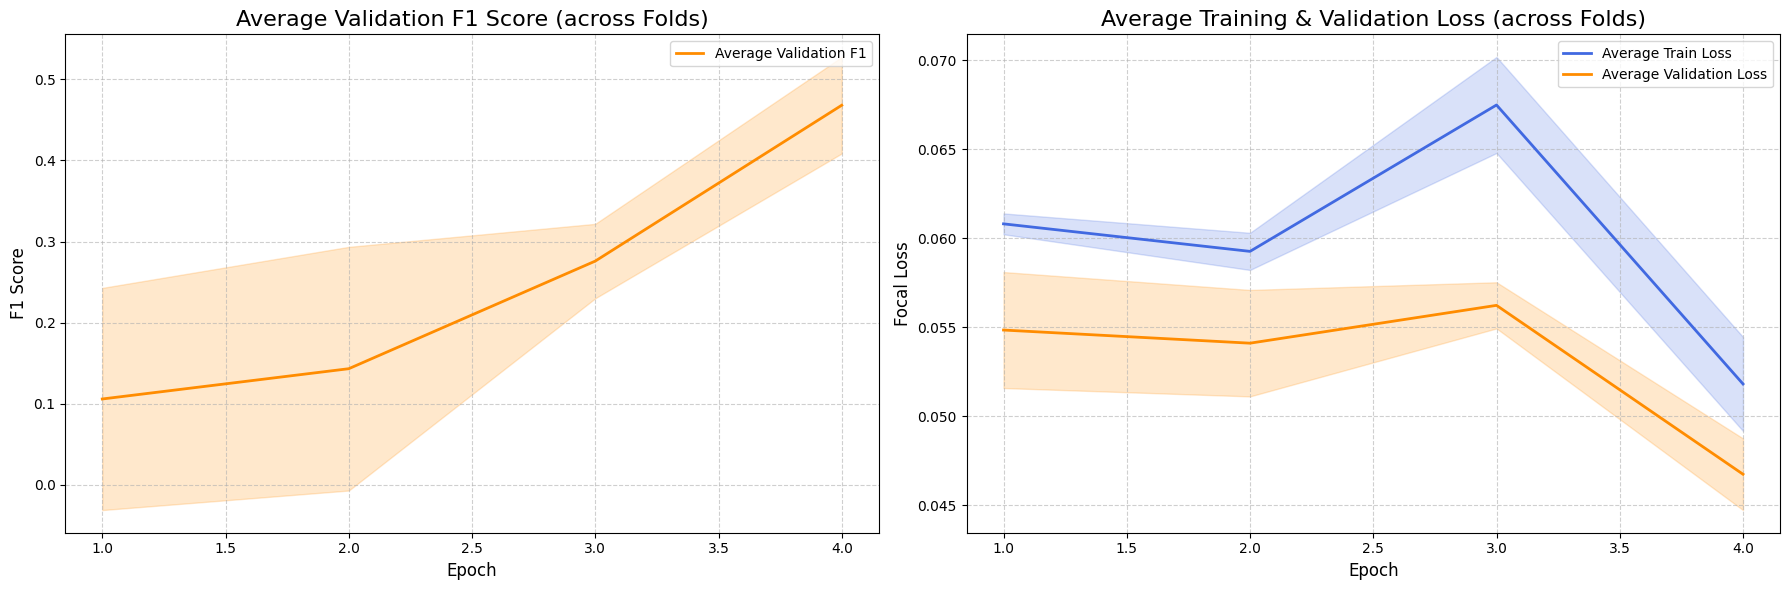

In [40]:
#       VISUALIZE TRAINING HISTORY 
# Plotting the AVERAGE learning curves across all K folds)
import matplotlib.pyplot as plt
import numpy as np

def plot_average_history(histories):
    """
    Plots the average training and validation loss and F1 scores across all folds.
    """
    print("\n--- Plotting average training history across all folds ---")
    
    if not histories:
        print("History object list is empty. Skipping plotting.")
        return

    # Create a figure with two subplots.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Calculate average and std dev for each metric
    min_epochs = min([len(h['val_loss']) for h in histories])
    val_f1_scores = np.array([h['val_f1_score'][:min_epochs] for h in histories])
    
    val_loss_scores = np.array([h['val_loss'][:min_epochs] for h in histories])
    train_loss_scores = np.array([h['loss'][:min_epochs] for h in histories])

    # Calculate the mean and standard deviation across the folds for each epoch.
    mean_val_f1 = np.mean(val_f1_scores, axis=0)
    std_val_f1 = np.std(val_f1_scores, axis=0)
    
    mean_val_loss = np.mean(val_loss_scores, axis=0)
    std_val_loss = np.std(val_loss_scores, axis=0)
    
    mean_train_loss = np.mean(train_loss_scores, axis=0)
    std_train_loss = np.std(train_loss_scores, axis=0)
    
    epochs = range(1, min_epochs + 1)

    # Plot 1: Average Validation F1 Score 
    ax1.plot(epochs, mean_val_f1, label='Average Validation F1', color='darkorange', lw=2)
    # Add a shaded region for the standard deviation.
    ax1.fill_between(epochs, mean_val_f1 - std_val_f1, mean_val_f1 + std_val_f1, color='darkorange', alpha=0.2)
    ax1.set_title('Average Validation F1 Score (across Folds)', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('F1 Score', fontsize=12)
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    #  Plot 2: Average Training & Validation Loss 
    ax2.plot(epochs, mean_train_loss, label='Average Train Loss', color='royalblue', lw=2)
    ax2.fill_between(epochs, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, color='royalblue', alpha=0.2)
    
    ax2.plot(epochs, mean_val_loss, label='Average Validation Loss', color='darkorange', lw=2)
    ax2.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, color='darkorange', alpha=0.2)

    ax2.set_title('Average Training & Validation Loss (across Folds)', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Focal Loss', fontsize=12)
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Call the new plotting function with our list of histories.
plot_average_history(oof_histories)

# 15. Classification Report

## 5.3 Performance Analysis 

### 1. Using Classification Report

- While the learning curves give us a view of the training process, this cell performs the definitive **quantitative evaluation** of our best-performing model. <br>
- The process is as follows:
1.  **Load Best ModelS:** These were saved weights for each fold in the cross-validation that achieved the highest F1 score during training.
2.  **Predict on Validation Data:** These models are used to make predictions on the validation set.
3.  **Optimize Decision Threshold:** For an imbalanced dataset, a standard threshold is rarely optimal. Thus the **best possible threshold** is determined by evaluating the F1 score across a range of values (0.1 to 0.9). This is a fine-tuning step that directly maximizes our success metric.
4.  **Generate Classification Report:** Finally, using the optimal threshold, we generate a report that provides a breakdown of the model's performance.
   
- This report is the tool for judging whether the model has met the first business objectives 

In [41]:
# CLASSIFICATION METRIC
from sklearn.metrics import classification_report, f1_score
import numpy as np
import logging
import warnings
import tensorflow as tf
import os

# === SUPPRESS ALL ANNOYING WARNINGS HERE ===
# This block will handle TensorFlow's verbose logging.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Suppress C++ level logs
tf.get_logger().setLevel(logging.ERROR) # Suppress Python level logs
# This specifically targets the AutoGraph warning by its text content.
warnings.filterwarnings("ignore", "AutoGraph could not transform", UserWarning)
#==============================================

print("--- Starting Detailed Model Evaluation ---")

# ==============================================================================
# CASE 1: EVALUATING THE RESULTS OF K-FOLD CROSS-VALIDATION
# ==============================================================================
if Config.USE_CROSS_VALIDATION:
    print(f"Mode: K-Fold Cross-Validation. Evaluating the performance across {Config.N_FOLDS} folds.")
    
    all_y_true_oof = []
    all_y_pred_proba_oof = []

    skf = StratifiedKFold(n_splits=Config.N_FOLDS, shuffle=True, random_state=Config.SEED)
    X_for_split = df.index
    y_for_split = df['label'].values

    for fold, (train_indices, val_indices) in enumerate(skf.split(X_for_split, y_for_split)):
        print(f"\n--- Evaluating Fold {fold + 1}/{Config.N_FOLDS} ---")
        
        full_tf_dataset = tf.data.TFRecordDataset(TRAIN_TFRECORD_PATH)
        
        # CORRECTED: Split the filter and map operations to remove the warning
        val_ds_raw_fold_with_index = full_tf_dataset.enumerate().filter(lambda i, data: tf.reduce_any(i == val_indices))
        val_ds_raw_fold = val_ds_raw_fold_with_index.map(lambda i, data: data)
        
        val_ds_for_eval = build_dataset(val_ds_raw_fold, is_training=False)
        
        y_val_true_fold = np.concatenate([y for x, y in val_ds_for_eval], axis=0)
        all_y_true_oof.extend(y_val_true_fold)

        model_weights_path = f"/kaggle/working/best_model_fold_{fold + 1}.weights.h5"
        print(f"Loading weights from: {model_weights_path}")
        with strategy.scope():
            evaluation_model = build_and_compile_model() 
            evaluation_model.load_weights(model_weights_path)
        
        val_pred_proba_fold = evaluation_model.predict(val_ds_for_eval)
        all_y_pred_proba_oof.extend(val_pred_proba_fold)

    all_y_true_oof = np.array(all_y_true_oof)
    all_y_pred_proba_oof = np.array(all_y_pred_proba_oof)

    print("\n--- Searching for the optimal decision threshold on OOF predictions... ---")
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_f1_oof = 0
    best_threshold_oof = 0.5
    for threshold in thresholds:
        y_val_pred_binary = (all_y_pred_proba_oof > threshold).astype(int)
        current_f1 = f1_score(all_y_true_oof, y_val_pred_binary)
        if current_f1 > best_f1_oof:
            best_f1_oof = current_f1
            best_threshold_oof = threshold
            
    print(f"Optimal OOF threshold found: {best_threshold_oof:.2f}")
    print(f"Best F1 Score on combined OOF predictions: {best_f1_oof:.4f}")
    
    print(f"\n--- Final OOF Classification Report (using optimal threshold of {best_threshold_oof:.2f}) ---\n")
    y_val_pred_optimal_oof = (all_y_pred_proba_oof > best_threshold_oof).astype(int)
    print(classification_report(all_y_true_oof, y_val_pred_optimal_oof, target_names=['No Landslide (0)', 'Landslide (1)']))

# ==============================================================================
# CASE 2: EVALUATING THE RESULTS OF A SINGLE 80/20 SPLIT
# ==============================================================================
else:
    print("Mode: Single 80/20 Split. Evaluating the single trained model.")
    model_weights_path = "best_model_single_split.weights.h5"
    val_ds_for_eval = val_dataset

    print("Extracting true labels from the validation dataset...")
    y_val_true = np.concatenate([y for x, y in val_ds_for_eval], axis=0)
    print(f"Validation data and {len(y_val_true)} true labels are ready.")

    print(f"Loading best model weights from: {model_weights_path}")
    with strategy.scope():
        evaluation_model = build_and_compile_model() 
        evaluation_model.load_weights(model_weights_path)
    print("Best weights loaded successfully into new model instance.")

    print("\n--- Getting predictions... ---")
    val_pred_proba = evaluation_model.predict(val_ds_for_eval)

    print("\n--- Searching for the optimal decision threshold... ---")
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_f1 = 0
    best_threshold = 0.5
    for threshold in thresholds:
        y_val_pred_binary = (val_pred_proba > threshold).astype(int)
        current_f1 = f1_score(y_val_true, y_val_pred_binary)
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
    
    best_threshold_final = best_threshold
    
    print(f"Optimal threshold found: {best_threshold_final:.2f}")
    print(f"Best F1 Score on this validation set: {best_f1:.4f}")

    print(f"\n--- Classification Report (using optimal threshold of {best_threshold_final:.2f}) ---\n")
    y_val_pred_optimal = (val_pred_proba > best_threshold_final).astype(int)
    print(classification_report(y_val_true, y_val_pred_optimal, target_names=['No Landslide (0)', 'Landslide (1)']))

--- Starting Detailed Model Evaluation ---
Mode: K-Fold Cross-Validation. Evaluating the performance across 3 folds.

--- Evaluating Fold 1/3 ---
Loading weights from: /kaggle/working/best_model_fold_1.weights.h5
--- Model built and compiled successfully with efficient F1 metric. ---
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 328ms/step

--- Evaluating Fold 2/3 ---
Loading weights from: /kaggle/working/best_model_fold_2.weights.h5
--- Model built and compiled successfully with efficient F1 metric. ---
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 325ms/step

--- Evaluating Fold 3/3 ---
Loading weights from: /kaggle/working/best_model_fold_3.weights.h5
--- Model built and compiled successfully with efficient F1 metric. ---
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 326ms/step

--- Searching for the optimal decision threshold on OOF predictions... ---
Optimal OOF threshold found: 0.51
Best F1 Score on combined OOF predictions: 0.4804

--- Final OOF Classification Report (using optimal threshold of 0.51) ---

                 

### 2. Confusion Matrix
- This heatmap shows the counts of correct and incorrect predictions for the two classes

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# This cell will now correctly handle both single-split and cross-validation modes.

if Config.USE_CROSS_VALIDATION:
    # In CV mode, we use the out-of-fold (OOF) predictions for the most robust evaluation.
    print("--- Displaying Confusion Matrix for Combined Out-of-Fold (OOF) Predictions ---")
    
    # These variables were created in the previous "Classification Report" cell
    y_true_for_cm = all_y_true_oof
    y_pred_for_cm = y_val_pred_optimal_oof
    title = f"Confusion Matrix (Combined OOF Results, Threshold={best_threshold_oof:.2f})"

else:
    # In single-split mode, we use the standard validation set predictions.
    print("--- Displaying Confusion Matrix for the 80/20 Validation Set ---")
    
    # These variables were created in the previous "Classification Report" cell
    y_true_for_cm = y_val_true
    y_pred_for_cm = y_val_pred_optimal
    title = f"Confusion Matrix (Single Split, Threshold={best_threshold_final:.2f})"

# Generate the confusion matrix
cm = confusion_matrix(y_true_for_cm, y_pred_for_cm)

# Plot the confusion matrix using a heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No Landslide', 'Predicted Landslide'],
            yticklabels=['Actual No Landslide', 'Actual Landslide'])
plt.title(title, fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

NameError: name 'y_val_true' is not defined

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_val_true, val_pred_proba)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Analysis of Misclassified Images

To understand the model's limitations, we can visualize some of the images it got wrong, helping identify any patterns in its errors.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Ensure Necessary Data is Available ===
print("Checking for necessary data...")
try:
    images_val.shape
    print("Validation images and predictions are already loaded.")
except NameError:
    print("Extracting data from the validation dataset...")
    y_val_true = np.concatenate([y for x, y in val_dataset], axis=0)
    images_val = np.concatenate([x for x, y in val_dataset], axis=0) 
    val_pred_proba = evaluation_model.predict(val_dataset)
    y_val_pred_optimal = (val_pred_proba > best_threshold).astype(int)
print("Data is ready.\n")


# === Step 2: Create a Reusable Plotting Function ===
def display_prediction_example(image_index, title_prefix):
    """
    Extracts, normalizes, and plots a single image example from the validation set.
    """
    # Get the specific image tensor and its associated labels/predictions
    image_tensor = images_val[image_index]
    true_label = int(y_val_true[image_index][0])
    predicted_prob = val_pred_proba[image_index][0]
    
    # Extract the RGB channels (first 3 channels) for a visual representation
    rgb_image = image_tensor[:, :, :3]
    
    # Normalize the pixel values to the [0, 1] range for correct plotting
    rgb_image_normalized = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min() + 1e-6)

    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image_normalized)
    plt.title(f"{title_prefix}\nTrue Label: {true_label} | Predicted Probability: {predicted_prob:.3f}", fontsize=16)
    plt.axis('off')
    plt.show()

    
# === Step 3: Find and Display a Correctly Identified Landslide (True Positive) ===
print("--- Displaying a Model Success (True Positive) ---")
true_positives_indices = np.where((y_val_true.flatten() == 1) & (y_val_pred_optimal.flatten() == 1))[0]

if len(true_positives_indices) > 0:
    # Get the index of the first true positive example
    example_index_tp = true_positives_indices[0]
    display_prediction_example(example_index_tp, "Correctly Identified Landslide")
else:
    print("No True Positives were found in the validation set to display.")
    
    
# === Step 4: Find and Display a Missed Landslide (False Negative) ===
print("\n--- Displaying a Model Failure (False Negative) ---")
false_negatives_indices = np.where((y_val_true.flatten() == 1) & (y_val_pred_optimal.flatten() == 0))[0]

if len(false_negatives_indices) > 0:
    # Get the index of the first false negative example
    example_index_fn = false_negatives_indices[0]
    display_prediction_example(example_index_fn, "Missed Landslide")
else:
    print("No False Negatives were found in the validation set to display.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from lime import lime_image
from skimage.segmentation import mark_boundaries

# === Step 1: Prepare Data for LIME Analysis ===
print("Extracting data from validation dataset for LIME analysis...")
try:
    images_val.shape # Check if this exists
    print("Required variables already exist.")
except NameError:
    print("Extracting images from the validation dataset...")
    y_val_true = np.concatenate([y for x, y in val_dataset], axis=0)
    images_val = np.concatenate([x for x, y in val_dataset], axis=0) 
    val_pred_proba = evaluation_model.predict(val_dataset)
    y_val_pred_optimal = (val_pred_proba > best_threshold).astype(int)
print(f"Ready to analyze {len(images_val)} validation images.\n")


# === Step 2: Create the LIME Explainer and Prediction Function ===

# Create an explainer object
explainer = lime_image.LimeImageExplainer()

def prediction_fn(images_for_lime):
    """
    A wrapper function that LIME uses to get predictions from our model.
    LIME generates RGB images, so we need to prepare them for our 15-channel model.
    """
    # LIME gives us images in a (num_samples, height, width, 3) shape.
    # We need to adapt this back to our model's 15-channel input.
    # This is a simple but effective strategy: we assume the perturbation 
    # mainly affects the visual (RGB) part and keep other channels constant.
    
    # We'll use the original image's non-RGB channels as a base
    original_image_non_rgb = images_val[idx_to_explain, :, :, 3:]
    
    # Create an array to hold the new 15-channel images
    num_samples = images_for_lime.shape[0]
    model_input = np.zeros((num_samples, 224, 224, 15))
    
    for i in range(num_samples):
        # The first 3 channels are from LIME's perturbed image
        model_input[i, :, :, :3] = images_for_lime[i]
        # The remaining 12 channels are from the original image
        model_input[i, :, :, 3:] = original_image_non_rgb
        
    # Get predictions from our trained CNN
    preds = evaluation_model.predict(model_input, batch_size=64, verbose=0)
    
    # LIME expects two outputs for binary classification: (prob_of_class_0, prob_of_class_1)
    return np.hstack((1 - preds, preds))


# === Step 3: Find and Explain a True Positive Example ===

print("Searching for a correctly identified landslide (True Positive) to visualize...")
true_positives_indices = [i for i in range(len(y_val_true)) if y_val_true.flatten()[i] == 1 and y_val_pred_optimal.flatten()[i] == 1]

if true_positives_indices:
    print(f"Found {len(true_positives_indices)} true positives. Displaying LIME for one example.")
    
    # Select the first true positive image to explain
    idx_to_explain = true_positives_indices[0]
    image_to_explain = images_val[idx_to_explain]
    
    # We'll use a normalized RGB version for LIME to process
    rgb_image = image_to_explain[:, :, :3]
    rgb_image_normalized = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min() + 1e-6)

    print("Generating LIME explanation... (This can take a few minutes)")
    # Generate the explanation
    explanation = explainer.explain_instance(
        rgb_image_normalized, 
        prediction_fn, 
        top_labels=2, 
        hide_color=0, 
        num_samples=1000 # Number of perturbed images to create
    )
    
    # Get the image and mask for the top class (which should be "Landslide")
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], 
        positive_only=True, 
        num_features=10, # Show the top 10 most influential superpixels
        hide_rest=True
    )
    
    # --- Plotting the Results ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"Explainability: Correctly Identified Landslide\nTrue: 1 | Pred Prob: {val_pred_proba[idx_to_explain][0]:.3f}", fontsize=16)

    # Plot original image
    axes[0].imshow(mark_boundaries(temp, mask))
    axes[0].set_title("LIME Explanation (Positive Regions)")
    axes[0].axis("off")
    
    # Plot False-Color for context
    nir_image = np.stack([image_to_explain[:,:,3], image_to_explain[:,:,0], image_to_explain[:,:,1]], axis=-1)
    nir_image = (nir_image - nir_image.min()) / (nir_image.max() - nir_image.min() + 1e-6)
    axes[1].imshow(nir_image)
    axes[1].set_title("False-Color Infrared View")
    axes[1].axis("off")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

else:
    print("No True Positives found in this validation set to display a LIME explanation.")

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from lime import lime_image
# from skimage.segmentation import mark_boundaries

# # === Step 1: Ensure Data is Available ===
# print("Preparing data for LIME analysis...")
# try:
#     images_val.shape
# except NameError:
#     images_val = np.concatenate([x for x, y in val_dataset], axis=0) 
#     y_val_true = np.concatenate([y for x, y in val_dataset], axis=0)
#     val_pred_proba = evaluation_model.predict(val_dataset)
#     y_val_pred_optimal = (val_pred_proba > best_threshold).astype(int)

# # === Step 2: Create a LIME Prediction Function ===
# explainer = lime_image.LimeImageExplainer()

# def prediction_fn_rgb(images_for_lime):
#     # This function is used by LIME to get predictions.
#     # It takes the RGB images LIME generates and adapts them for our 15-channel model.
#     original_non_rgb = images_val[idx_to_explain, :, :, 3:]
#     num_samples = images_for_lime.shape[0]
#     model_input = np.zeros((num_samples, 224, 224, 15))
#     for i in range(num_samples):
#         model_input[i, :, :, :3] = images_for_lime[i]
#         model_input[i, :, :, 3:] = original_non_rgb
#     preds = evaluation_model.predict(model_input, batch_size=64, verbose=0)
#     return np.hstack((1 - preds, preds))

# # === Step 3: Find a True Positive Example ===
# true_positives_indices = [i for i in range(len(y_val_true)) if y_val_true.flatten()[i] == 1 and y_val_pred_optimal.flatten()[i] == 1]

# if true_positives_indices:
#     print("\n--- Generating New, Clearer SHAP Explanation for a Correctly Identified Landslide ---")
#     idx_to_explain = true_positives_indices[0] # Using the same index for consistency
#     image_to_explain = images_val[idx_to_explain]
    
#     # Prepare the normalized RGB image that LIME will use as its base
#     rgb_image = image_to_explain[:, :, :3]
#     rgb_image_normalized = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min() + 1e-6)

#     print("Generating LIME explanation... (This may take a few minutes)")
#     explanation = explainer.explain_instance(
#         rgb_image_normalized, 
#         prediction_fn_rgb, 
#         top_labels=1, 
#         hide_color=0, 
#         num_samples=1000
#     )
    
#     # Get the explanation mask where we only highlight the most positive regions
#     temp, mask = explanation.get_image_and_mask(
#         explanation.top_labels[0], 
#         positive_only=True, 
#         num_features=5, # Highlight the top 5 most important segments
#         hide_rest=False # IMPORTANT: Do not hide the rest of the image
#     )
    
#     # Create the False-Color Infrared image for comparison
#     nir_image = np.stack([image_to_explain[:,:,3], image_to_explain[:,:,0], image_to_explain[:,:,1]], axis=-1)
#     nir_image = (nir_image - nir_image.min()) / (nir_image.max() - nir_image.min() + 1e-6)

#     # === Step 4: Plot the Improved 3-Panel Visualization ===
#     fig, axes = plt.subplots(1, 3, figsize=(20, 7))
#     fig.suptitle(f"Explainability: Correctly Identified Landslide\nTrue: 1 | Pred Prob: {val_pred_proba[idx_to_explain][0]:.3f}", fontsize=20)

#     # Panel 1: True-Color Image (What our eyes see)
#     axes[0].imshow(rgb_image_normalized)
#     axes[0].set_title("1. True-Color View (Human Eye)", fontsize=14)
#     axes[0].axis("off")

#     # Panel 2: False-Color Infrared (Highlights vegetation loss)
#     axes[1].imshow(nir_image)
#     axes[1].set_title("2. False-Color View (Vegetation Map)", fontsize=14)
#     axes[1].axis("off")
    
#     # Panel 3: LIME Explanation (Highlights what the AI found important)
#     axes[2].imshow(mark_boundaries(temp, mask))
#     axes[2].set_title("3. AI's Focus (Highlighted Regions)", fontsize=14)
#     axes[2].axis("off")
    
#     plt.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.show()

# else:
#     print("No True Positives found to explain.")

In [ ]:
# import lime
# import lime.lime_tabular
# import numpy as np
# import pandas as pd

# # === Step 1: Create the LIME Explainer for Tabular Data ===

# # We need to give the explainer the training data so it knows the distribution of each feature.
# # We'll use the feature names from your selected features.
# explainer = lime.lime_tabular.LimeTabularExplainer(
#     training_data=X_train.values,
#     feature_names=X_train.columns.tolist(),
#     class_names=['No Landslide', 'Landslide'],
#     mode='classification'
# )


# # === Step 2: Select an Instance to Explain ===

# # Let's find a landslide from the test set that the model correctly identified.
# # Note: We use X_test here, which was created in your notebook for the tree models.
# y_pred_lgbm = best_lgbm.predict(X_test)
# true_positives_df_indices = X_test[(y_test == 1) & (y_pred_lgbm == 1)].index

# if not true_positives_df_indices.empty:
#     # Get the index of the first true positive example
#     idx_to_explain = true_positives_df_indices[0]
    
#     print(f"--- Generating LIME Explanation for a Correctly Identified Landslide (LightGBM) ---")
#     print(f"Explaining instance with DataFrame index: {idx_to_explain}\n")

#     # === Step 3: Generate and Display the Explanation ===
    
#     # Get the explanation for this specific row of data
#     explanation = explainer.explain_instance(
#         data_row=X_test.loc[idx_to_explain].values,
#         predict_fn=best_lgbm.predict_proba,
#         num_features=10  # Show the top 10 most influential features
#     )

#     # You can print the explanation as a list
#     print("Top features contributing to the 'Landslide' prediction:")
#     for feature, weight in explanation.as_list(label=1):
#         print(f"- {feature}: {weight:.4f}")
        
#     # Or, for a more visual output in a notebook, display it as an HTML object
#     explanation.show_in_notebook(show_table=True, show_all=False)

# else:
#     print("No correctly identified landslides found in the test set to explain.")

# TRUE POSITIVE

In [ ]:
# import shap
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# from lime import lime_image
# from skimage.segmentation import mark_boundaries

# # === Step 1: Prepare Data for Analysis ===
# print("Extracting data from validation dataset for LIME analysis...")
# try:
#     images_val.shape # Check if this exists
#     print("Required variables already exist.")
# except NameError:
#     print("Extracting images from the validation dataset...")
#     y_val_true = np.concatenate([y for x, y in val_dataset], axis=0)
#     images_val = np.concatenate([x for x, y in val_dataset], axis=0) 
#     val_pred_proba = evaluation_model.predict(val_dataset)
#     y_val_pred_optimal = (val_pred_proba > best_threshold).astype(int)
# print(f"Ready to analyze {len(images_val)} validation images.\n")


# # === Step 2: Create a LIME Explainer ===
# explainer = lime_image.LimeImageExplainer()

# def create_prediction_fn(original_15_channel_image):
#     """
#     This is a factory that creates a prediction function for a specific image.
#     This is necessary so that LIME, which works with 3-channel RGB images,
#     can get predictions from our 15-channel model.
#     """
#     # Extract the non-RGB channels from the original image.
#     # These will be 'stapled' back onto the RGB perturbations LIME creates.
#     original_non_rgb = original_15_channel_image[:, :, 3:]

#     def prediction_fn_for_lime(rgb_images_from_lime):
#         num_samples = rgb_images_from_lime.shape[0]
#         model_input = np.zeros((num_samples, 224, 224, 15))
        
#         for i in range(num_samples):
#             # The first 3 channels are from LIME's perturbed image
#             model_input[i, :, :, :3] = rgb_images_from_lime[i]
#             # The remaining channels are from the original image
#             model_input[i, :, :, 3:] = original_non_rgb
            
#         preds = evaluation_model.predict(model_input, batch_size=64, verbose=0)
#         # LIME expects two outputs for binary classification: (prob_of_class_0, prob_of_class_1)
#         return np.hstack((1 - preds, preds))
    
#     return prediction_fn_for_lime


# # === Step 3: Find and Display Multiple Examples ===

# print("Searching for correctly identified landslides (True Positives) to visualize...")
# true_positives_indices = np.where((y_val_true.flatten() == 1) & (y_val_pred_optimal.flatten() == 1))[0]

# if true_positives_indices.size > 0:
#     num_to_display = min(20, len(true_positives_indices))
#     print(f"Found {len(true_positives_indices)} true positives. Displaying LIME explanations for {num_to_display} examples.")
#     print("NOTE: This will take a significant amount of time to complete.")

#     # Select the first N indices to display for consistency
#     indices_to_show = true_positives_indices[:num_to_display]

#     for i, img_idx in enumerate(indices_to_show):
#         print(f"\n--- Generating LIME explanation for image {i + 1}/{num_to_display} (Validation Set Index: {img_idx}) ---")
        
#         # Get the full 15-channel image to be explained
#         image_to_explain = images_val[img_idx]
        
#         # Create the specialized prediction function for THIS specific image
#         prediction_function = create_prediction_fn(image_to_explain)
        
#         # Prepare the normalized RGB version for LIME's visual processing
#         rgb_image_normalized = (image_to_explain[:, :, :3] - image_to_explain[:, :, :3].min()) / \
#                                (image_to_explain[:, :, :3].max() - image_to_explain[:, :, :3].min() + 1e-6)

#         # Generate the explanation
#         explanation = explainer.explain_instance(
#             rgb_image_normalized, 
#             prediction_function, 
#             top_labels=1, 
#             hide_color=0, 
#             num_samples=1000 # Use 1000 samples for a robust explanation
#         )
        
#         # Get the explanation mask, showing only the positive evidence on the full image
#         temp, mask = explanation.get_image_and_mask(
#             explanation.top_labels[0], 
#             positive_only=True, 
#             num_features=5, 
#             hide_rest=False 
#         )
        
#         # Prepare the False-Color image for comparison
#         nir_image = np.stack([image_to_explain[:,:,3], image_to_explain[:,:,0], image_to_explain[:,:,1]], axis=-1)
#         nir_image = (nir_image - nir_image.min()) / (nir_image.max() - nir_image.min() + 1e-6)

#         # Plot the 3-panel visualization
#         fig, axes = plt.subplots(1, 3, figsize=(20, 7))
#         fig.suptitle(f"Explainability Example #{i+1}\nTrue Label: 1 | Pred Prob: {val_pred_proba[img_idx][0]:.3f}", fontsize=20)

#         axes[0].imshow(rgb_image_normalized); axes[0].set_title("1. True-Color View (Human Eye)"); axes[0].axis("off")
#         axes[1].imshow(nir_image); axes[1].set_title("2. False-Color View (Vegetation Map)"); axes[1].axis("off")
#         axes[2].imshow(mark_boundaries(temp, mask)); axes[2].set_title("3. AI's Focus (Highlighted Regions)"); axes[2].axis("off")
        
#         plt.tight_layout(rect=[0, 0, 1, 0.95])
#         plt.show()

# else:
#     print("No True Positives found in this validation set to display a LIME explanation.")

# Load Best Model and Evaluate on Validation Set
This cell performs the definitive evaluation of our best model on the data it didn't train on. It answers the question: "How well did our model truly perform?"

# 16. Create the Test Dataset
First, we need to create a tf.data.Dataset for our test images. We will use our powerful build_dataset functioN.

# 6. **Deployment**

## 6.1 Prepare the Test Dataset

- This cell defines a new set of `get_parse_test_function`and `build_test_dataset` functions for the test set. This pipeline is almost identical to the one for validation data, with the key difference being it does not parse or expect a label, as none exists for the test data. <br>
- Operations perfromed:
1.  **Parse & Decode:** Reads the raw test data from the `test.tfrecord` file.
2.  **Engineer Features:** Applies the exact same feature engineering function (`engineer_features`) using the same global statistics that were calculated from the training set to ensure the model sees the test data in the same format it was trained on.
3.  **Scale & Resize:** Performs the identical scaling and resizing operations.

- Finally, it constructs the `test_dataset` object, batching the data and using `.prefetch()` to ensure an efficient prediction process.

In [ ]:
# CREATE THE TEST DATASET

def get_parse_test_function(stats):
    """
    This is a factory that creates our TEST data parsing function. 
    It "closes over" the stats dictionary, making it available for normalization.
    """
    # Convert the stats dictionary to a TensorFlow constant
    stats_tensor = {k: tf.constant(v, dtype=tf.float32) for k, v in stats.items()}
    @tf.function
    def parse_test_tfrecord_function(example_proto):
        """
        Parses a single tf.train.Example proto for TEST data.
        """
        feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'id': tf.io.FixedLenFeature([], tf.string),
        }
        
        parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        
        # Decode and Reshape the Base Image 
        image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float64)
        image = tf.cast(image, tf.float32)
        image = tf.reshape(image, [*Config.IMAGE_SIZE, 12])
        
        # Call the feature engineering function, which now returns ONE tensor
        image_with_features = engineer_features(image, stats_tensor)
        
        # Standard Preprocessing on the final combined tensor
        image_resized = tf.image.resize(image_with_features, Config.TARGET_SIZE, method='bilinear')
        image_scaled = image_resized / 255.0
        
        final_image = tf.ensure_shape(image_scaled, [*Config.TARGET_SIZE, Config.N_CHANNELS])
        image_id = parsed_features['id']
        
        return final_image, image_id

    return parse_test_tfrecord_function

# --- Second, define the build function for the test dataset ---
def build_test_dataset(tfrecord_path, stats):
    """
    Builds a high-performance tf.data.Dataset for inference.
    It now requires the global_stats to create the correct parser.
    """
    # Create the specific parsing function for this dataset
    parse_fn = get_parse_test_function(stats)
    
    dataset = tf.data.TFRecordDataset(tfrecord_path, num_parallel_reads=tf.data.AUTOTUNE)
    dataset = dataset.map(parse_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(Config.BATCH_SIZE, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# --- Execute the build process ---
print("--- Building final test dataset for inference (with unified feature engineering)... ---\n")
# The global_stats dictionary should be available from a previous cell
if 'global_stats' in locals():
    test_dataset = build_test_dataset(TEST_TFRECORD_PATH, global_stats)
    print("--- Test dataset built successfully. ---")
    
    # Sanity check to confirm the output shapes
    print("\n--- Inspecting a batch from the test dataset... ---")
    for images, ids in test_dataset.take(1):
        print("Image batch shape:", images.shape)
        print("ID batch shape:", ids.shape)
else:
    print("ERROR: `global_stats` dictionary not found. Please run the cell that calculates global statistics first.")

# 17. Ensemble Predictions and Create Submission File
Runs the final inference, formats the output, and saves the file 

1. Iterative Loading: It loops from 1 to 5, loading the weights from each of your saved "expert" models (model_fold_1.weights.h5, model_fold_2.weights.h5, etc.).

2. Prediction Gathering: It gets a separate set of predictions on the test data from each of the 5 models.

3. Ensembling: It takes the average of these 5 sets of predictions. This final ensembled_predictions array is more robust and less prone to individual model errors than any single prediction would be.

4. Submission: It creates the submission.csv using these final, averaged probabilities, ensuring compliance with the competition rules.

## 6.2 Generate Final Predictions with Test-Time Augmentation (TTA)

- To maximize the accuracy of our final output, a technique called **Test-Time Augmentation (TTA)** is employed. <br>
- The TTA process involves:
1.  **Original Prediction:** We first generate a baseline set of predictions on the original, unaltered test images.
2.  **Augmented Predictions:** We then create two augmented versions of the test dataset: one with a horizontal flip and another with a vertical flip. We generate a new set of predictions for each of these augmented versions.
3.  **Ensemble Averaging:** Finally, we **average the prediction probabilities** from all three views (original, horizontal flip, vertical flip) for each test image. This ensembling technique often leads to more stable and accurate final predictions by reducing the impact of any random artifacts in the test images.

- Finally a `submission.csv` files is created using the optimal threshold we discovered during our evaluation phase.

In [ ]:

# 17. PREDICT WITH TTA AND CREATE MULTIPLE SUBMISSION FILES

print("--- Starting prediction with Test Time Augmentation (TTA) ---")

# --- 1. Load your best trained model ---
# This assumes you are running this after a single 80/20 training run
model_weights_path = "best_model_single_split.weights.h5" 
print(f"Loading model weights from: {model_weights_path}")

with strategy.scope():
    # Re-build the model architecture exactly as it was during training
    prediction_model = build_and_compile_model()
    prediction_model.load_weights(model_weights_path)

print("Model loaded successfully.")

# --- 2. Create the clean test dataset for TTA ---
print("Building a clean, non-augmented test dataset for TTA...")
test_dataset_tta = build_test_dataset(TEST_TFRECORD_PATH, global_stats)

# --- 3. Perform TTA Predictions ---
print("Generating TTA predictions (this may take a moment)...")

# Original predictions
original_preds = prediction_model.predict(test_dataset_tta, verbose=1)

# Horizontal Flip predictions
tta_hflip = test_dataset_tta.map(lambda img, id: (tf.image.flip_left_right(img), id))
hflip_preds = prediction_model.predict(tta_hflip, verbose=1)

# Vertical Flip predictions
tta_vflip = test_dataset_tta.map(lambda img, id: (tf.image.flip_up_down(img), id))
vflip_preds = prediction_model.predict(tta_vflip, verbose=1)

# --- 4. Average the predictions ---
# Averaging the probabilities from 3 different "views" of each image
final_predictions = (original_preds + hflip_preds + vflip_preds) / 3.0
print("...TTA predictions averaged successfully.")

# --- 5. Create and Save Submission Files with a Loop ---
print("\n--- Creating final submission files for different thresholds... ---")

# Define the thresholds you want to test
thresholds_to_submit = {
    "tuned_threshold": best_threshold, # The optimal one from your validation set
    "standard_threshold": 0.5         # The standard baseline
}

for name, threshold_value in thresholds_to_submit.items():
    print(f"\nProcessing submission for: '{name}' with threshold = {threshold_value:.4f}")
    
    # Create the DataFrame
    submission_df = pd.DataFrame({
        'ID': test_df['ID'].values,
        'Target': (final_predictions.flatten() > threshold_value).astype(int)
    })

    # Define the filepath
    submission_filepath = f"submission_tta_{name}.csv"
    
    # Save the file
    submission_df.to_csv(submission_filepath, index=False)

    print(f"-> Submission file created: {submission_filepath}")
    print("File head:")
    print(submission_df.head())

print("\n--- All submission files created successfully! ---") 